## Early Prediction of Sepsis Based on Machine Learning Algorithm
    - https://onlinelibrary.wiley.com/doi/10.1155/2021/6522633

    - DATABASE: https://physionet.org/content/challenge-2019/1.0.0/

In [1]:
import os
import glob
import dill
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import miceforest as mf
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_auc_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [2]:
path = "zhao_2021/training_setA"
files = glob.glob(os.path.join(path, '*.psv'))

dfs = []
for file in files:
    df = pd.read_csv(file, delimiter='|')
    has_sepsis = df['SepsisLabel'].eq(1).any()
    if has_sepsis:  
        df['Age'] = df['Age'].astype(int)
        df['Gender'] = df['Gender'].astype(int)
        df = df.drop(columns=['Unit1', 'Unit2', 'HospAdmTime', 'EtCO2'])
        dfs.append(df)
files = None

In [3]:
path = "zhao_2021/training_setB"
files = glob.glob(os.path.join(path, '*.psv'))

dfs_B = []
for file in files:
    df = pd.read_csv(file, delimiter='|')
    has_sepsis = df['SepsisLabel'].eq(1).any()
    if has_sepsis:  
        df['Age'] = df['Age'].astype(int)
        df['Gender'] = df['Gender'].astype(int)
        df = df.drop(columns=['Unit1', 'Unit2', 'HospAdmTime', 'EtCO2'])
        dfs_B.append(df)
        
files = None

In [4]:
feature_cols = [
    'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
    'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
    'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
    'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
    'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
    'Age', 'Gender'
]

In [5]:
# Comparar a Distribuição dos Dados Originais e Imputados
def plot_distribution_comparison(original_data, imputed_data, columns, title):
    for column in columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(original_data[column].dropna(), color='red', label='Original', kde=True)
        sns.histplot(imputed_data[column], color='black', label='Imputed', kde=True)
        plt.title(f'{title} - Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

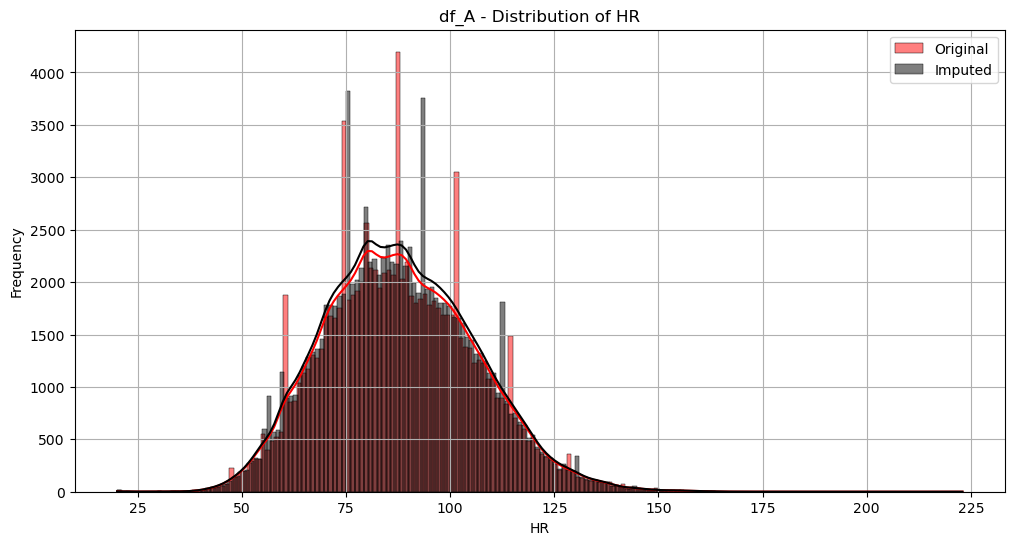

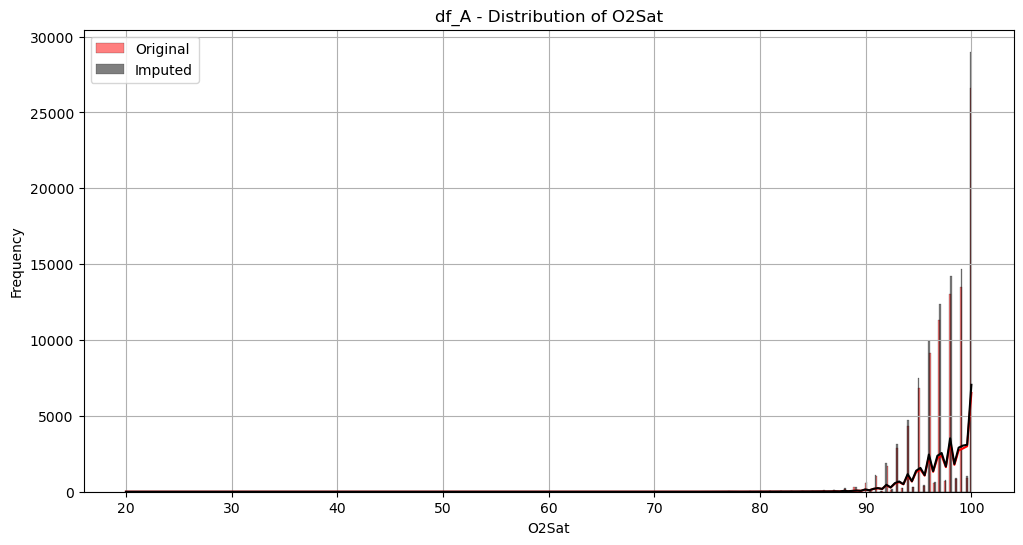

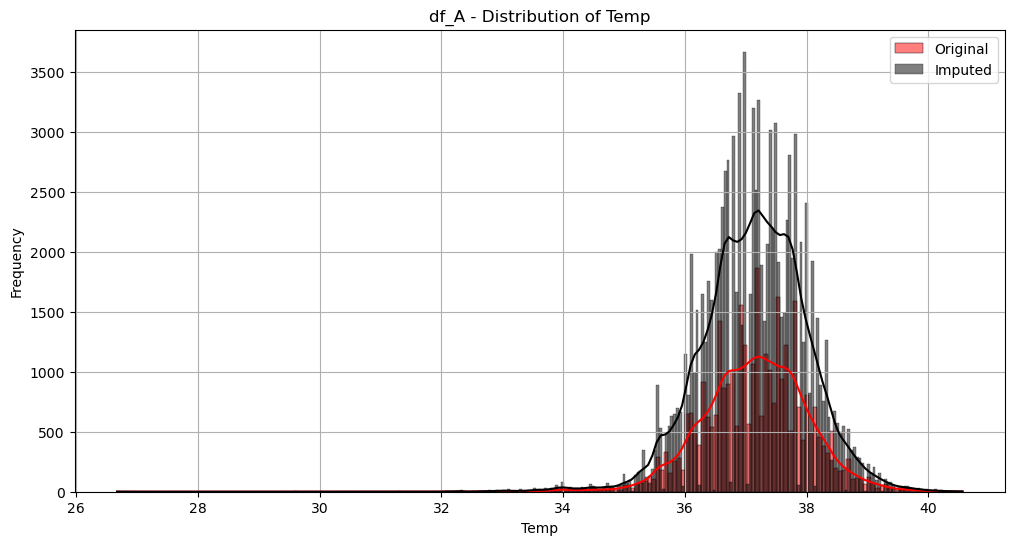

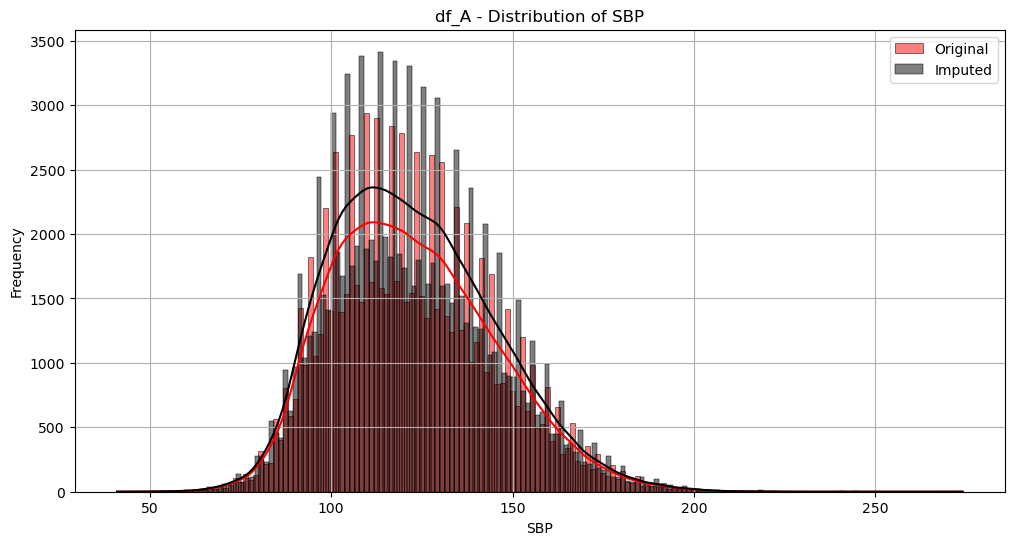

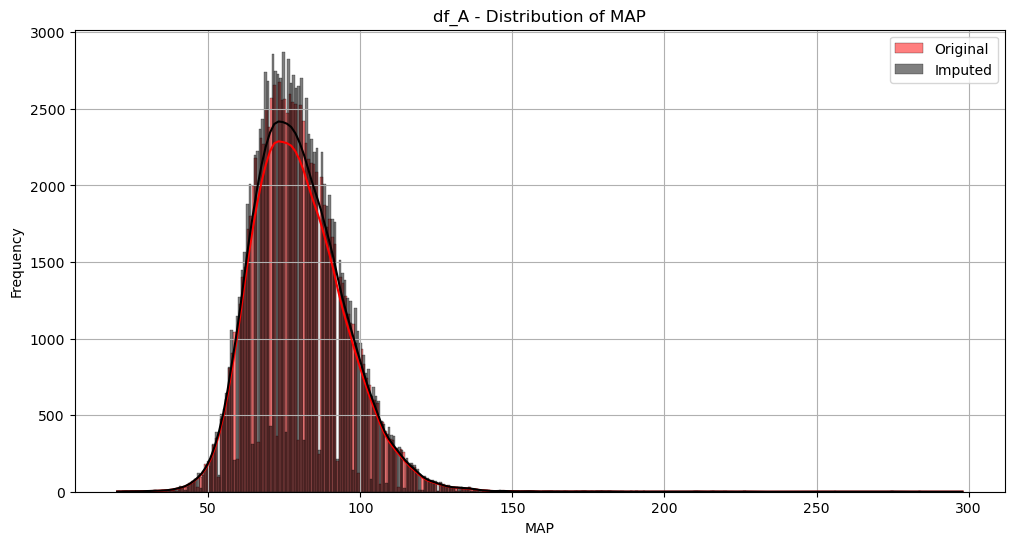

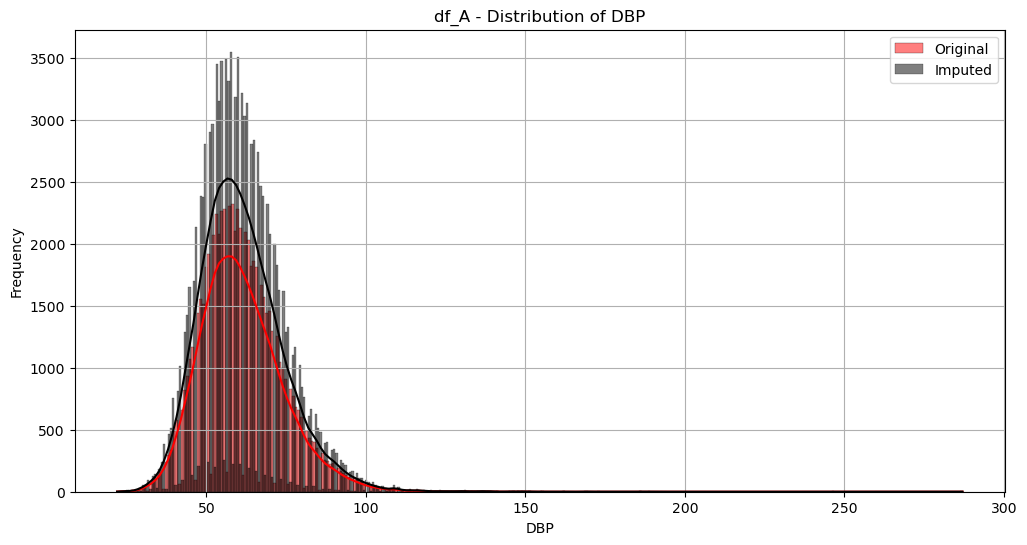

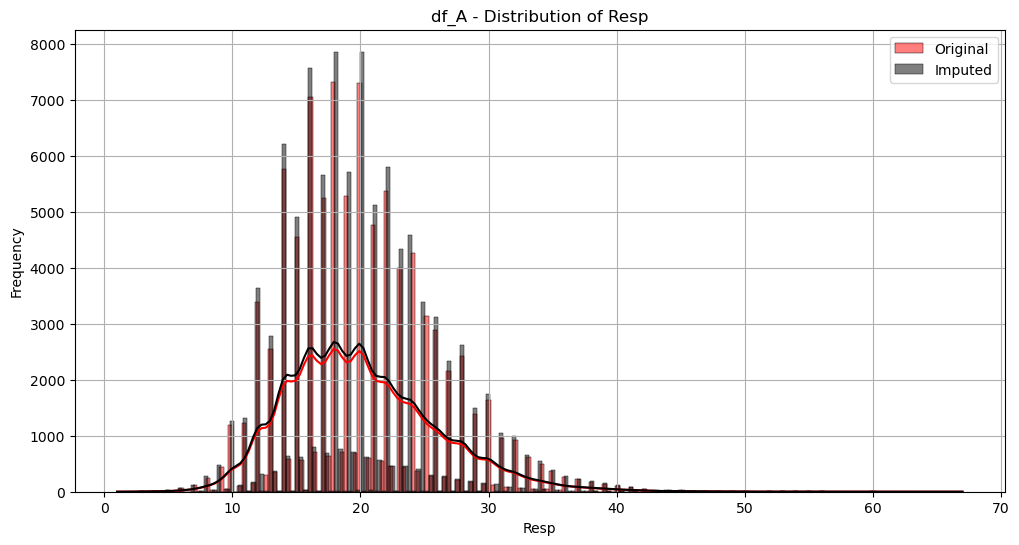

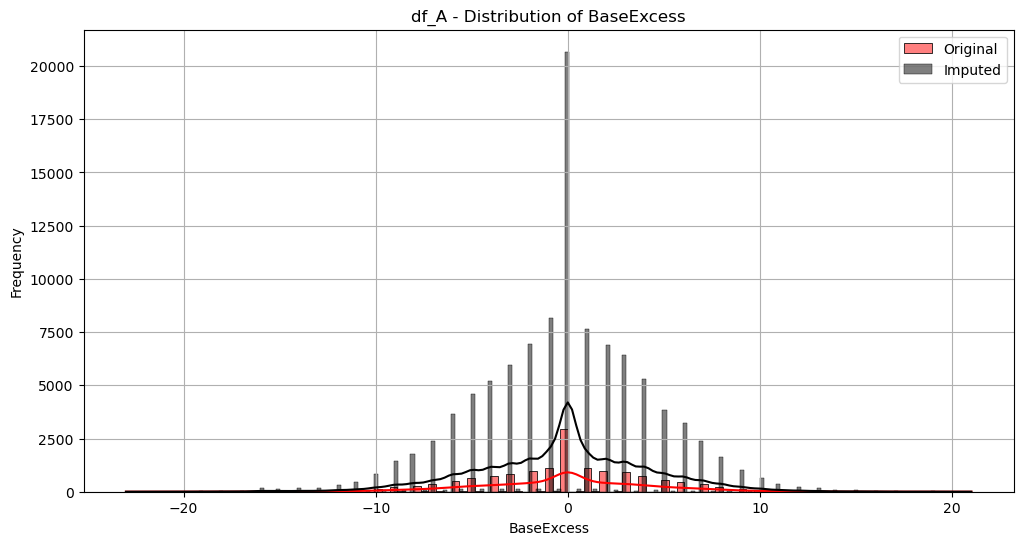

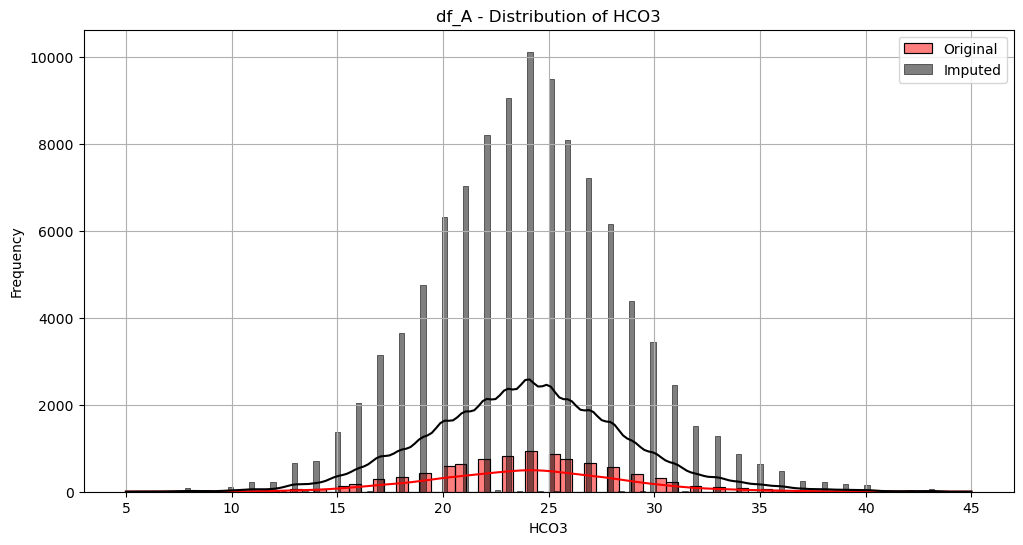

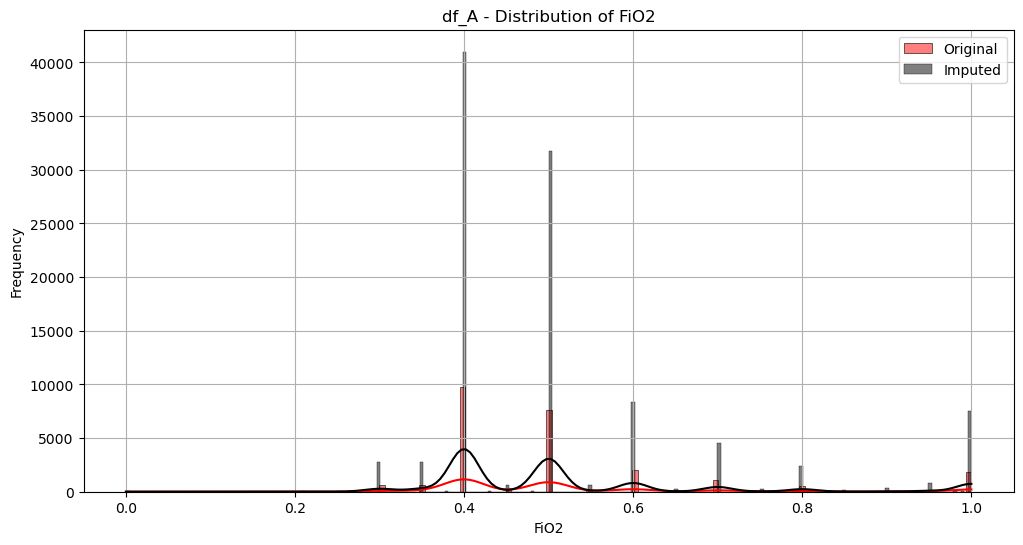

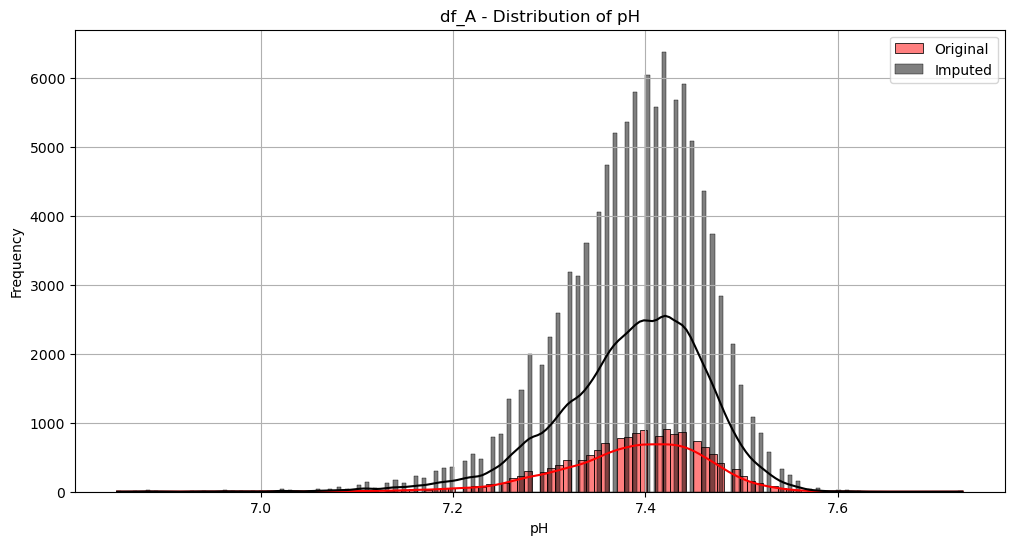

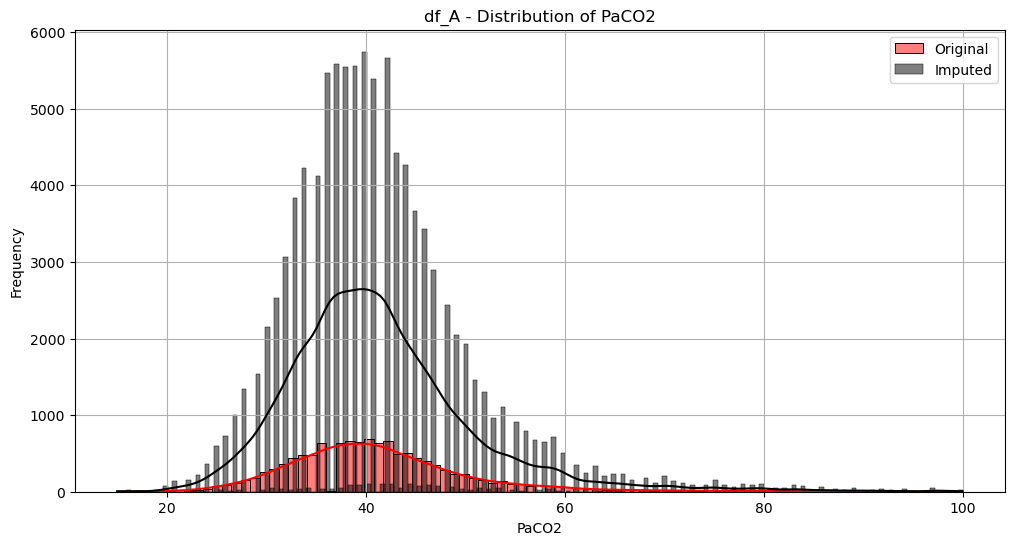

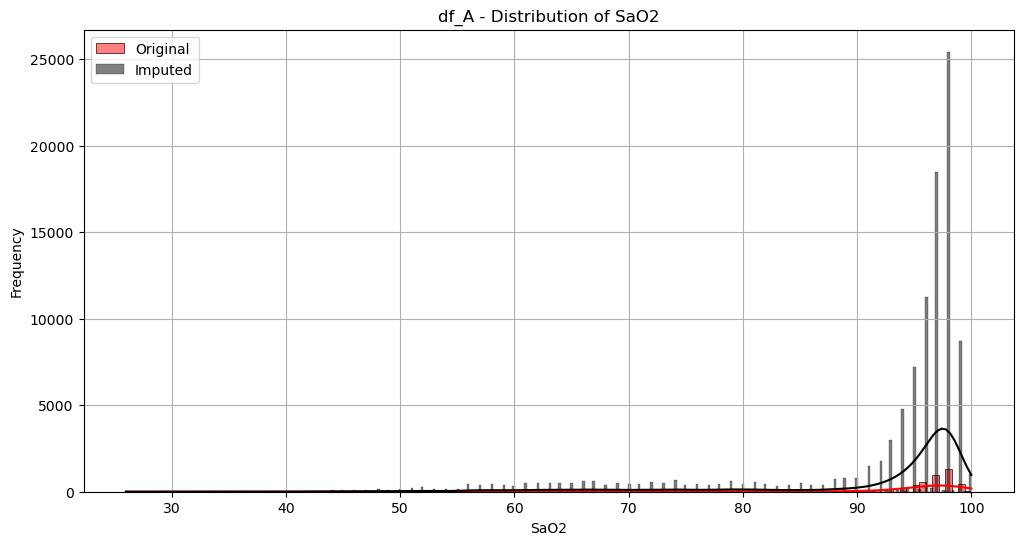

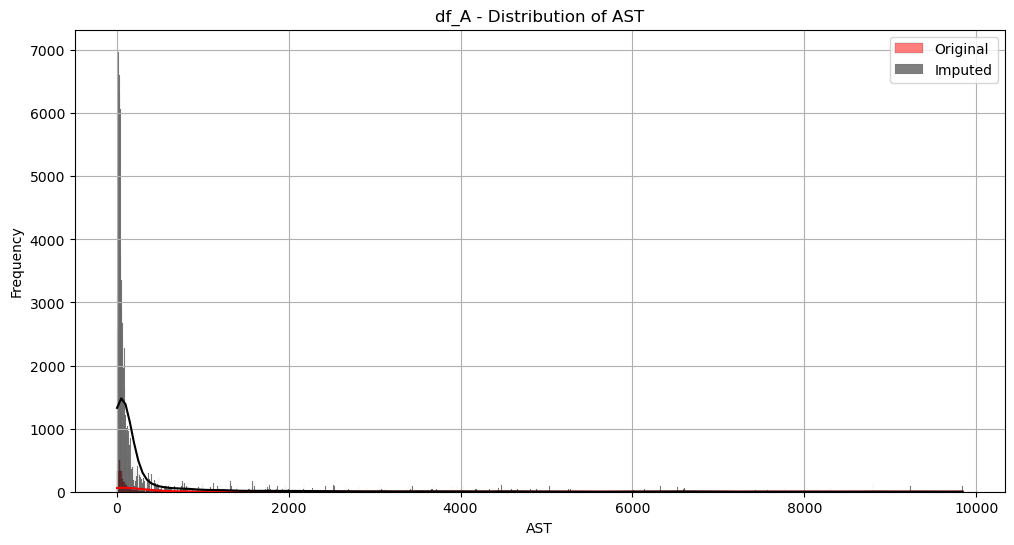

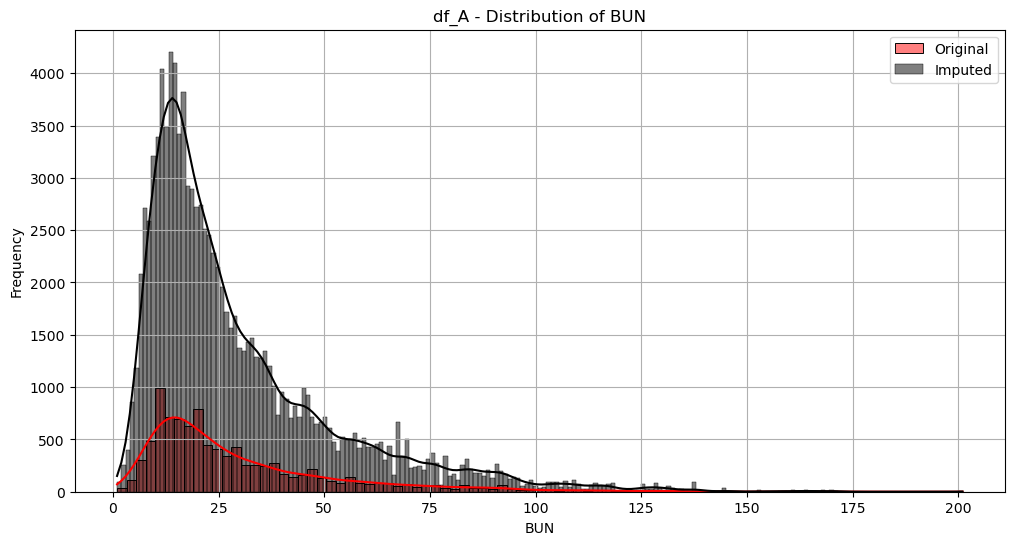

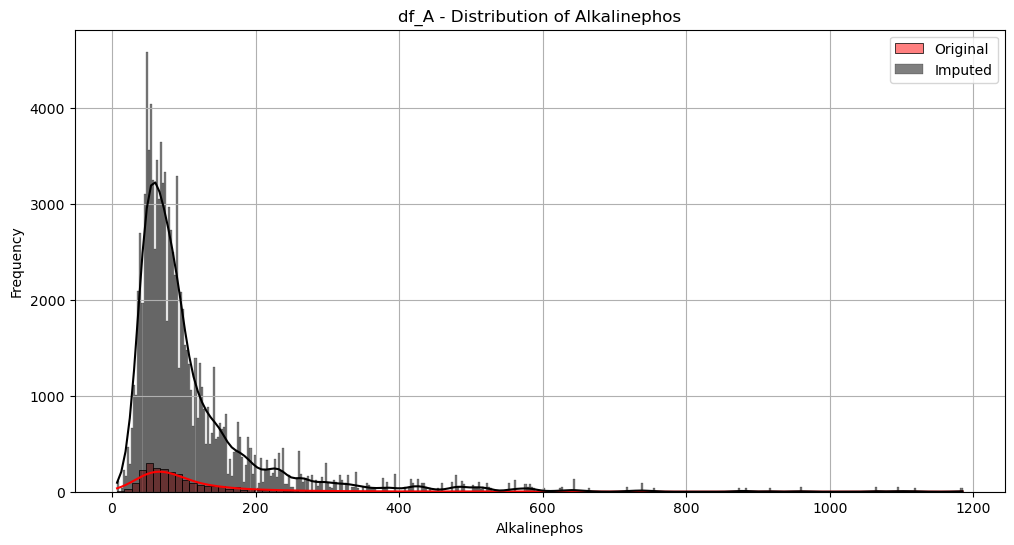

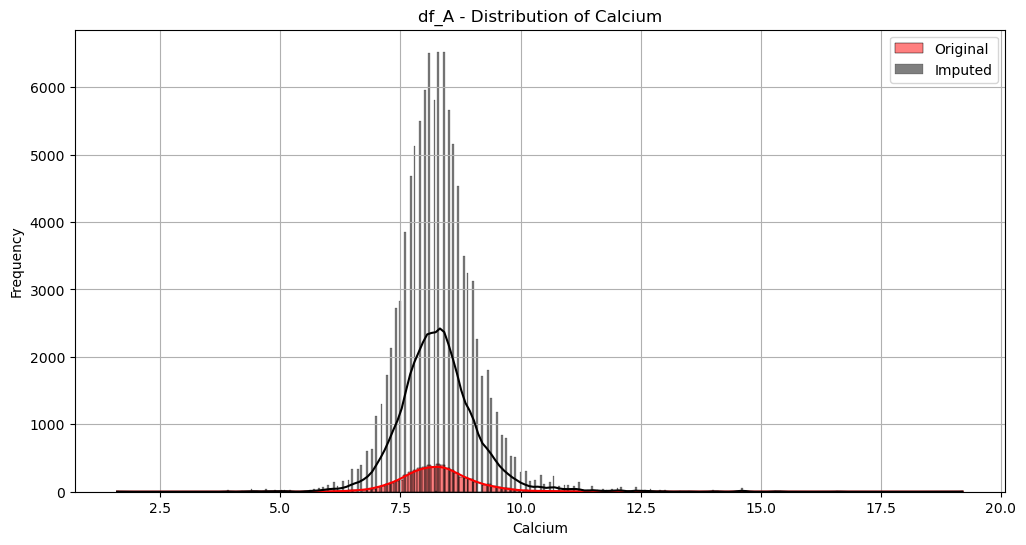

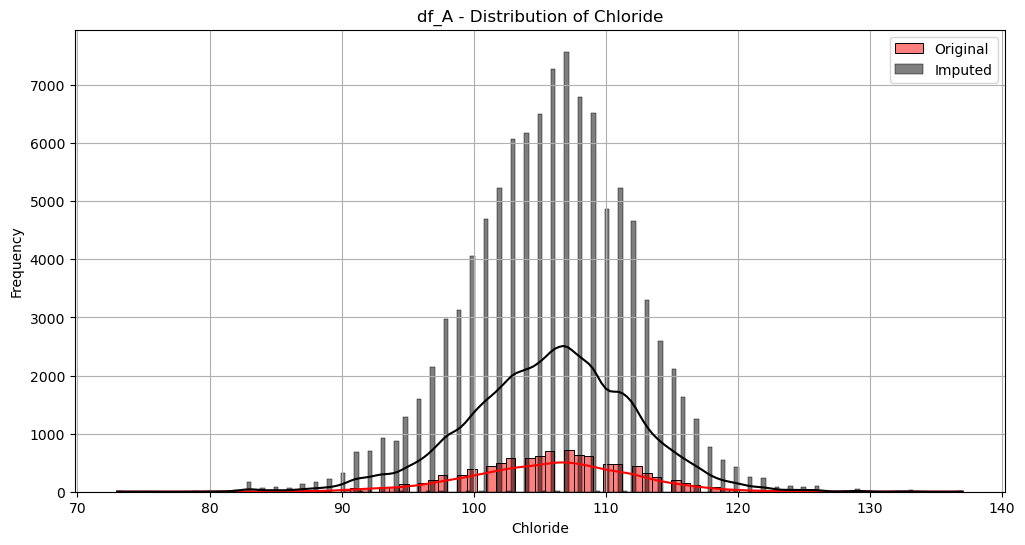

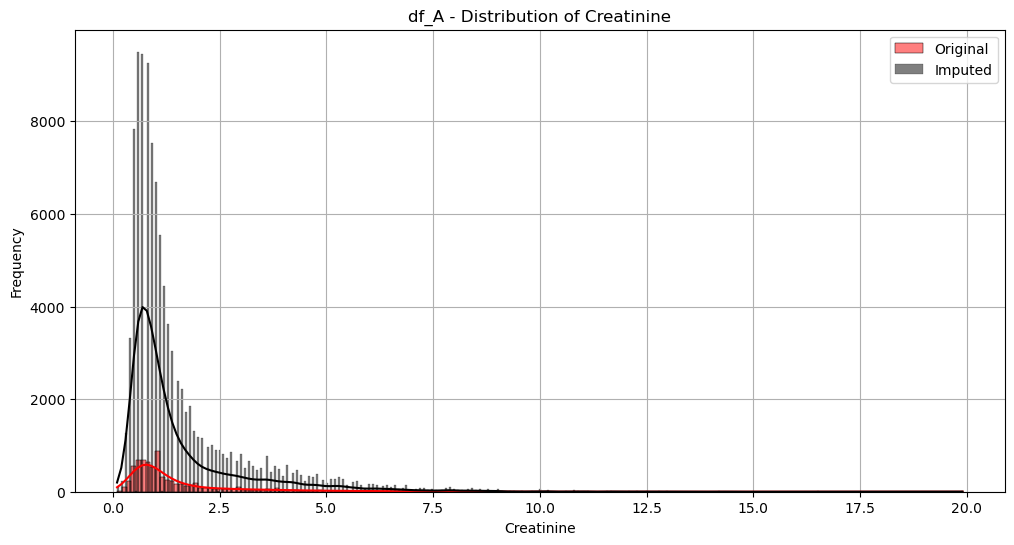

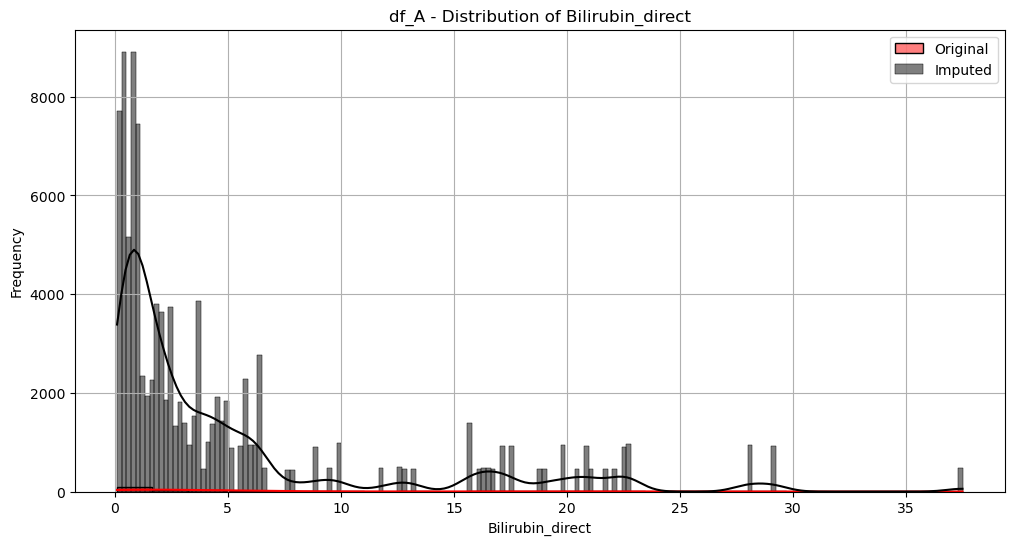

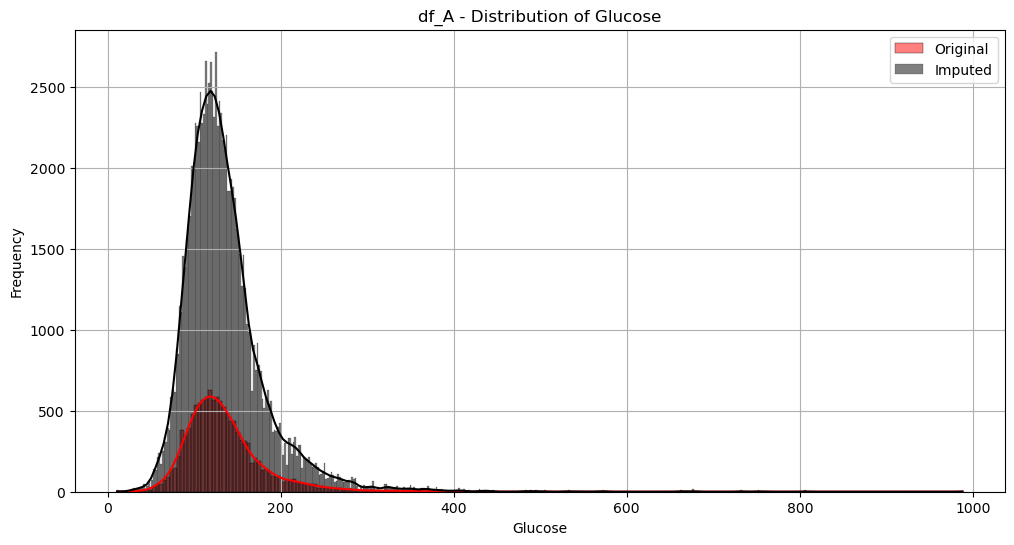

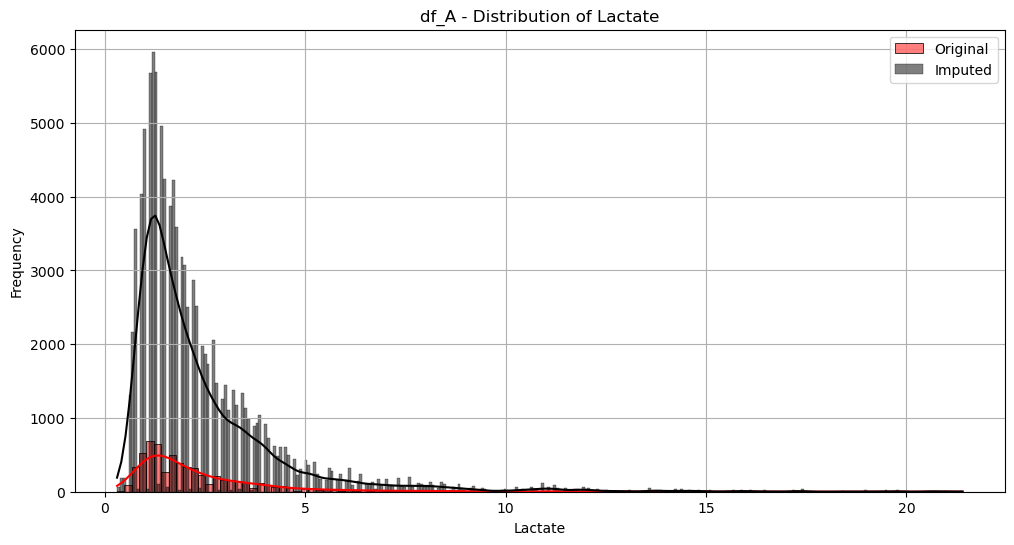

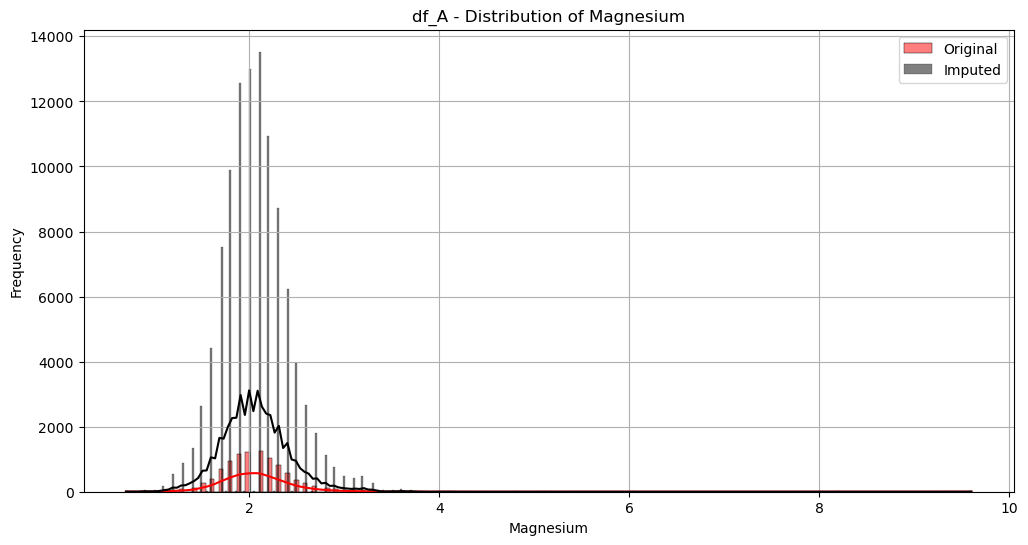

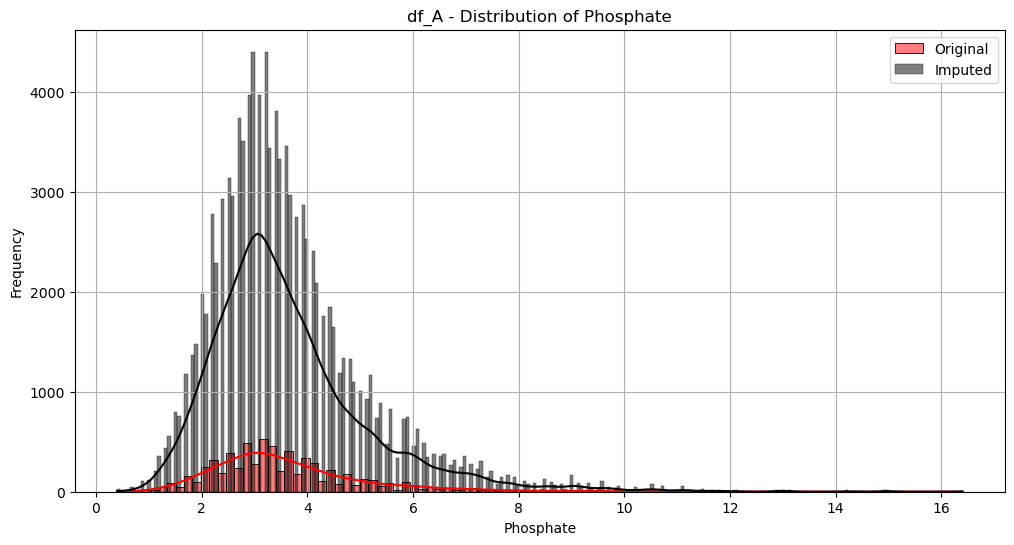

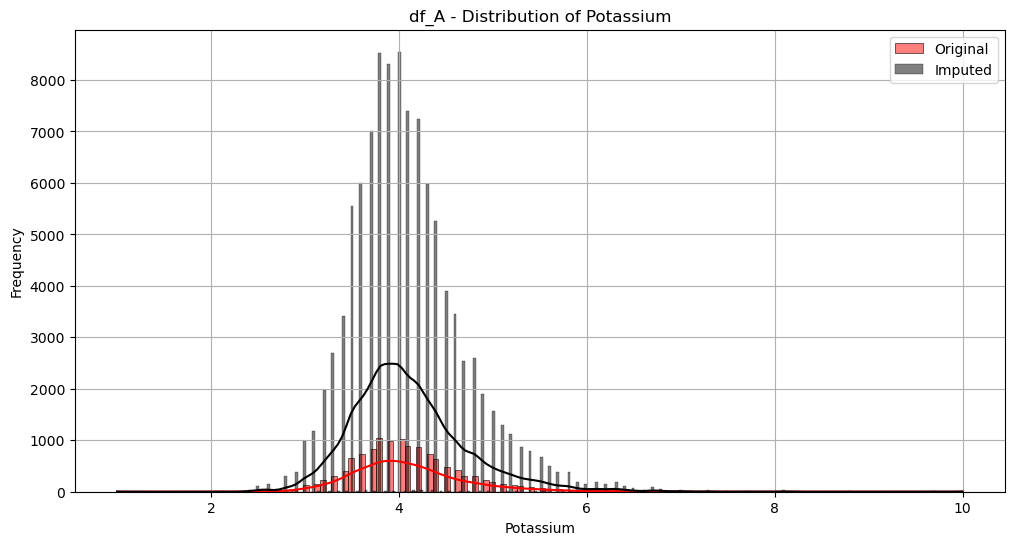

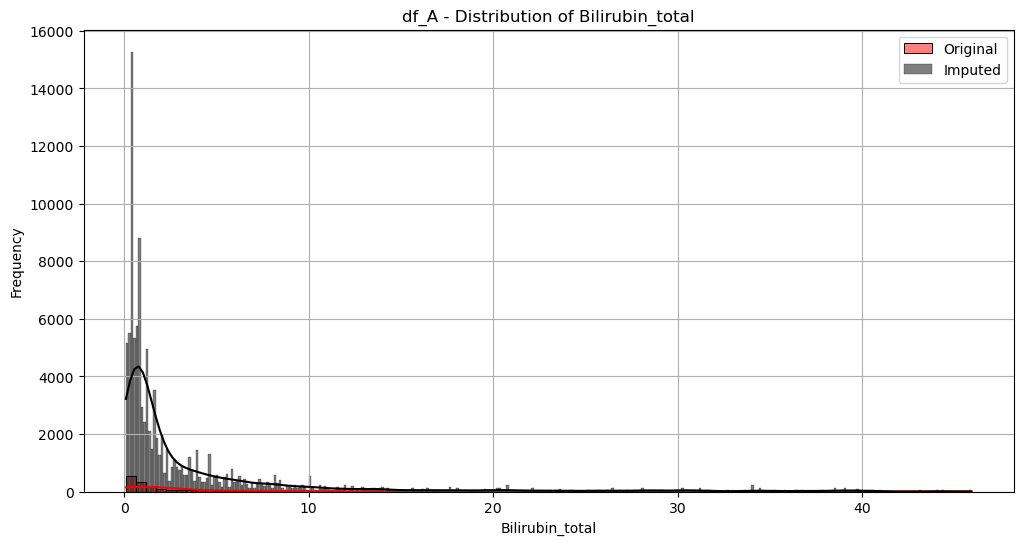

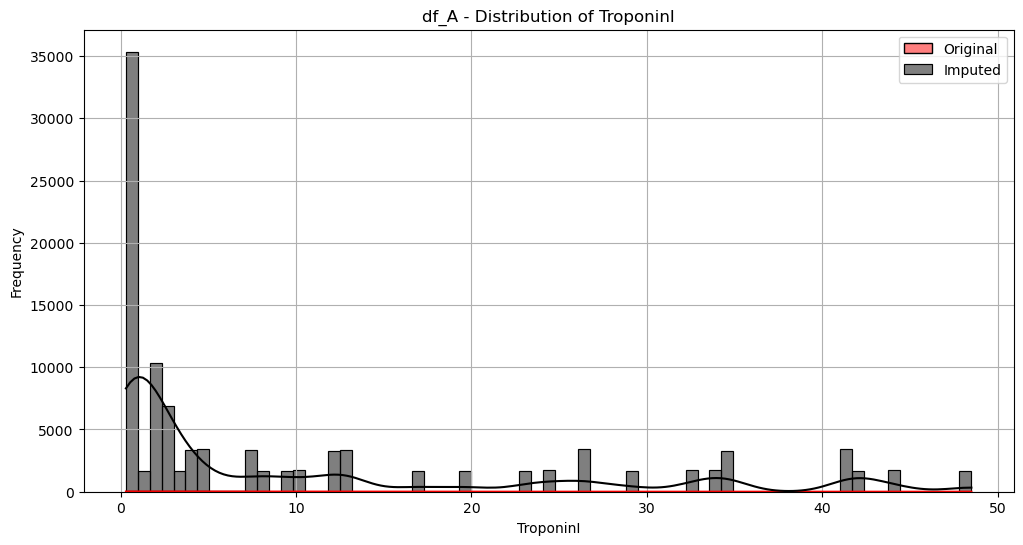

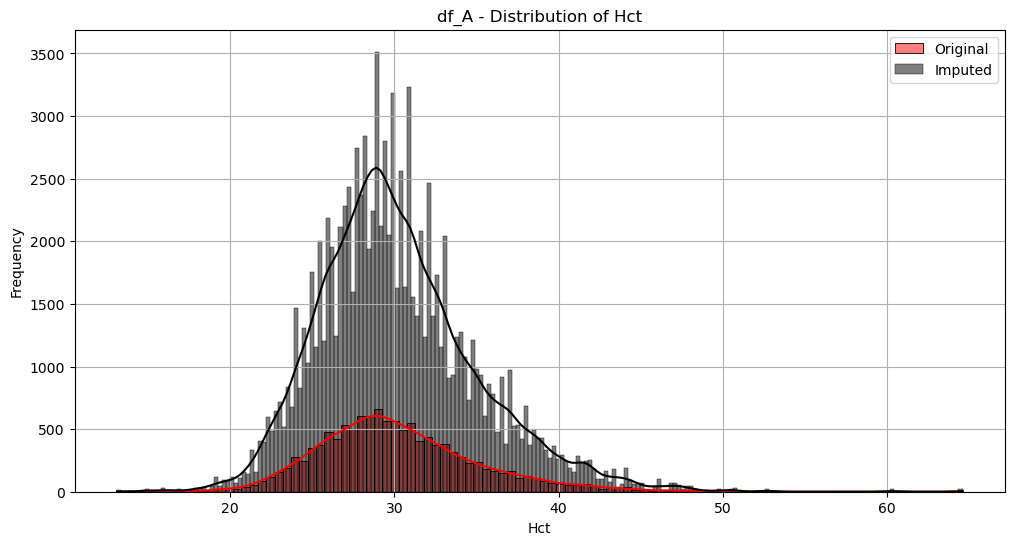

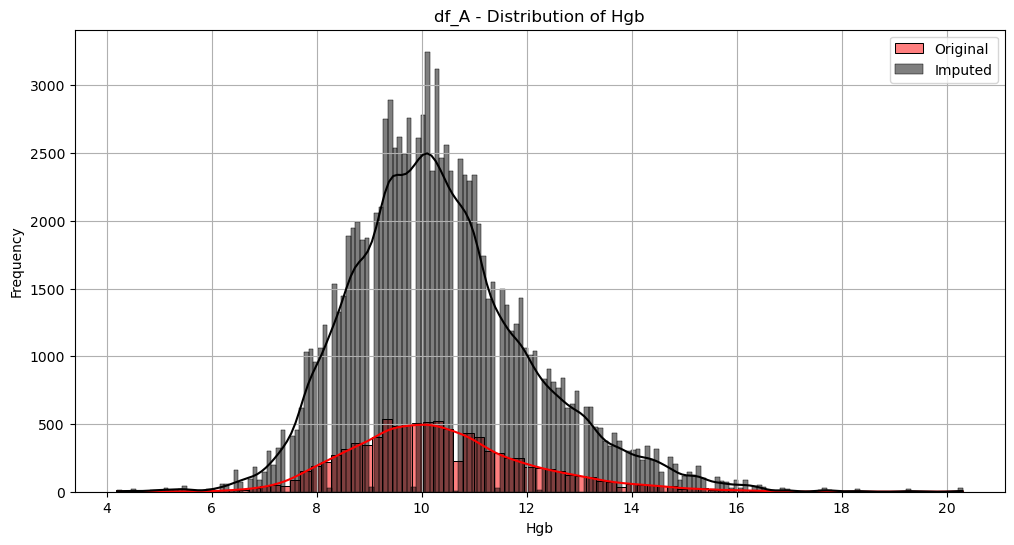

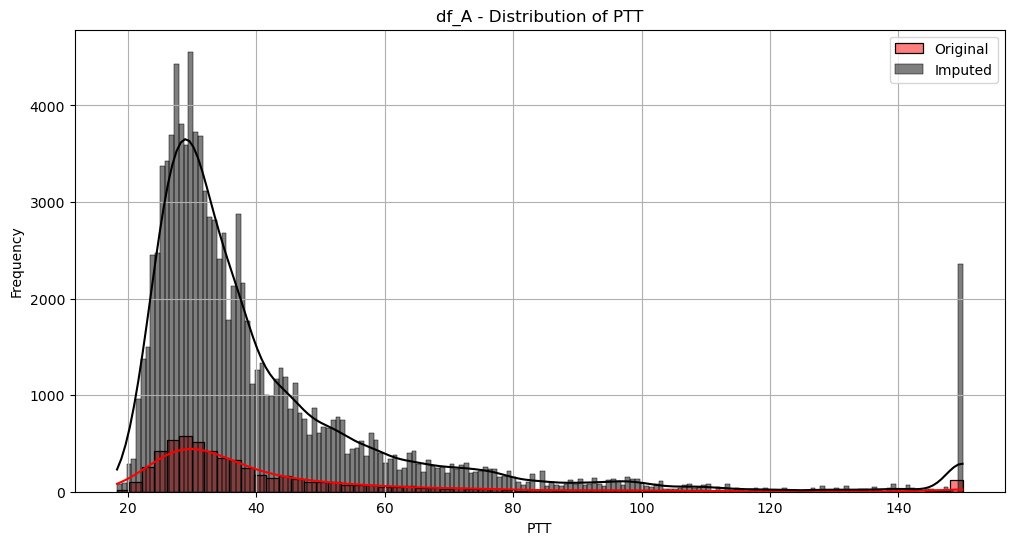

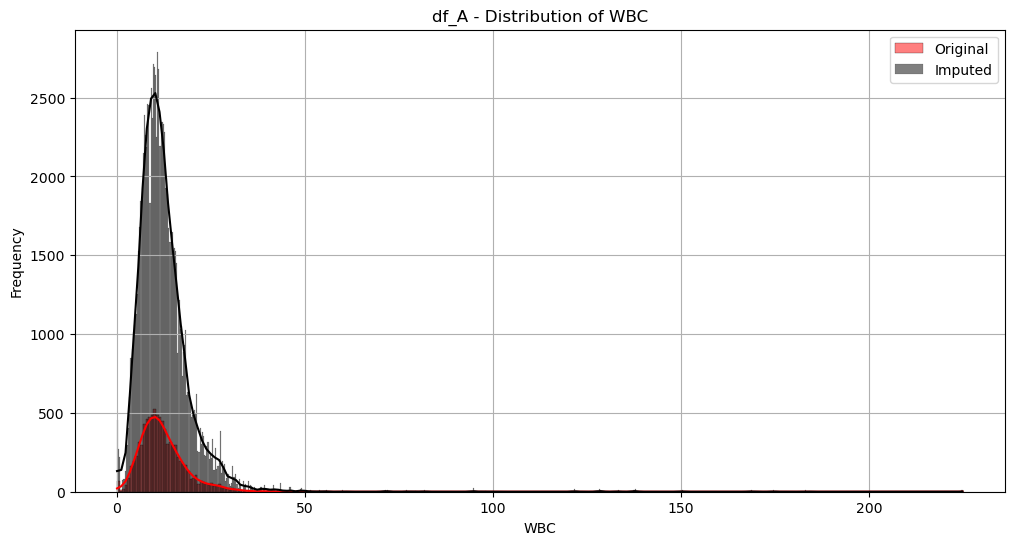

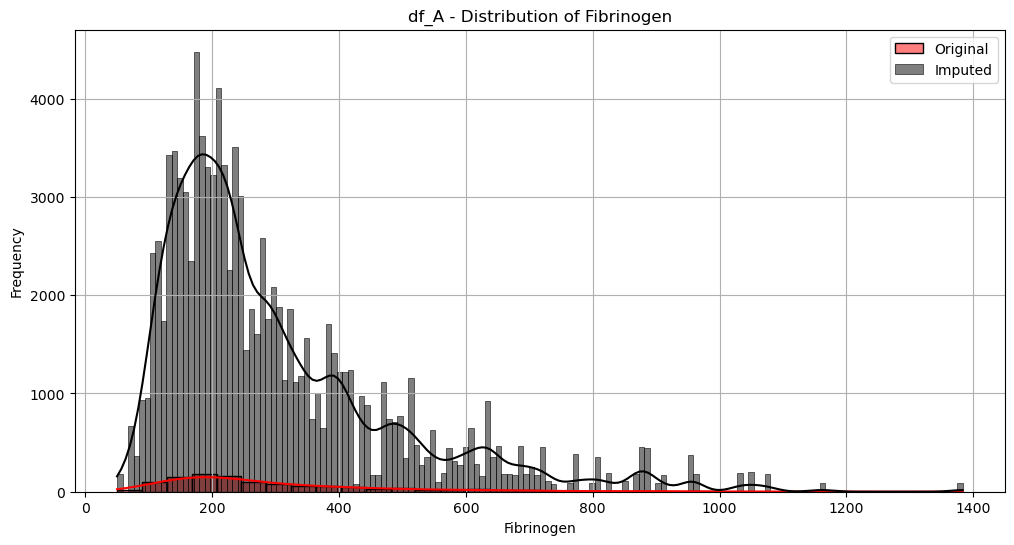

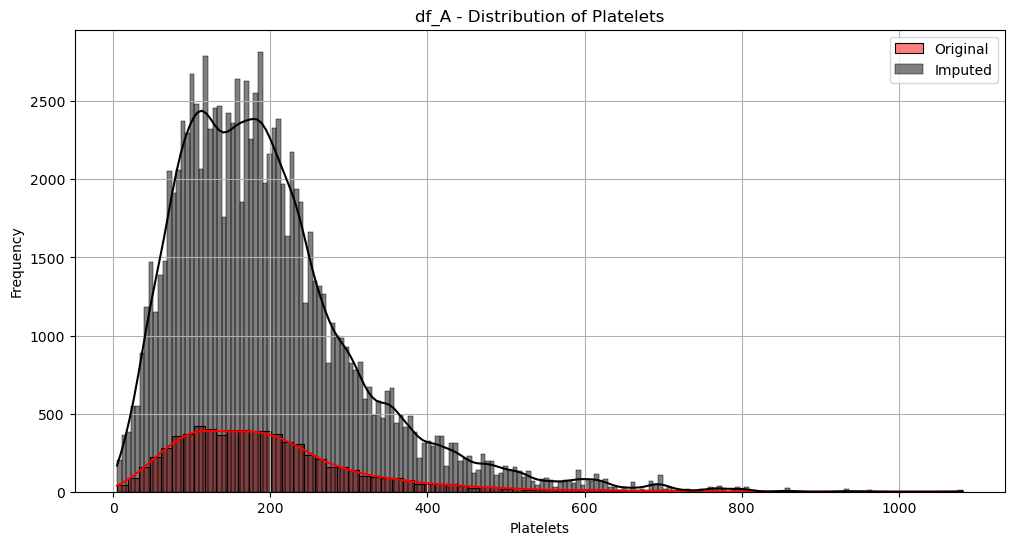

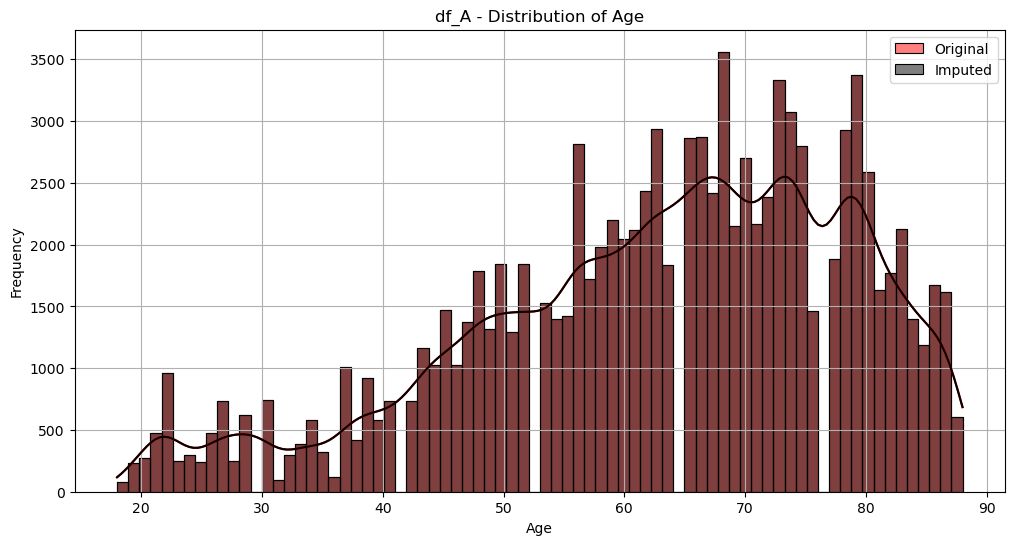

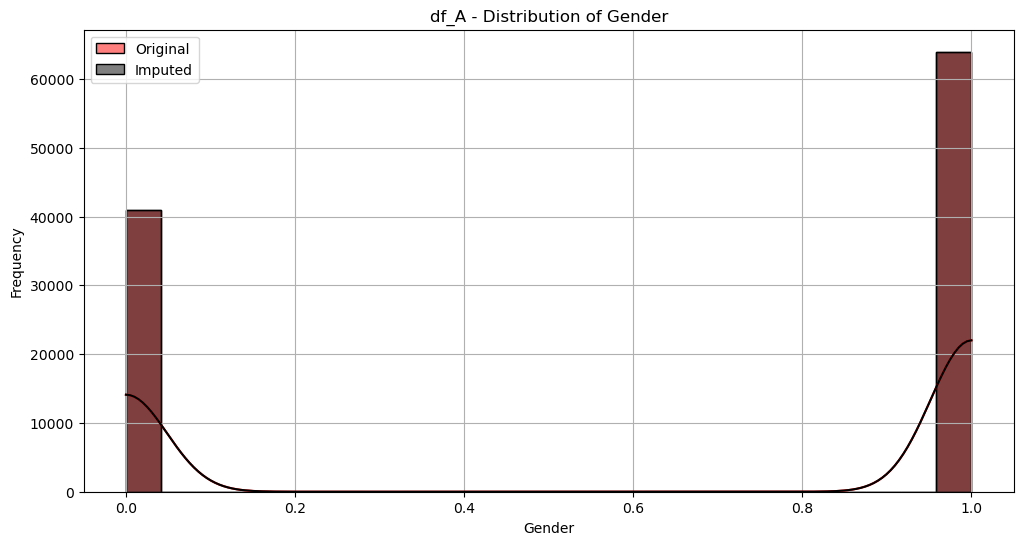

In [6]:
df_A = pd.concat(dfs, ignore_index=True)
df_A = df_A[feature_cols]
column_types = df_A.dtypes

kernel = mf.ImputationKernel(df_A, num_datasets=1, random_state=182)
pipe = Pipeline([
    ('impute', kernel),
])
# usar pipe.transform(new_data) para dados não vistos ainda
df_A_transformed = pipe.fit_transform(
    X=df_A,
    y=None,
    impute__iterations=5
)

# plot_distribution_comparison(df_A, df_A_transformed, df_A.columns, 'df_A')

### Feature Generation

In [7]:
def count_non_nan(row, columns):
    count = 0
    for col in columns:
        value = row[col]
        if pd.notna(value):
            count += 1
    return count

In [8]:
def calculate_stats(df, col, window_size):
    df[f'{col}_{window_size}h_max'] = df[col].rolling(window=window_size, min_periods=1).max()
    df[f'{col}_{window_size}h_min'] = df[col].rolling(window=window_size, min_periods=1).min()
    df[f'{col}_{window_size}h_maxmin'] = df[f'{col}_{window_size}h_max'] - df[f'{col}_{window_size}h_min']
    return df

In [9]:
def calculate_qSOFA(df):
    df['qSOFA'] = 0
    df.loc[df['Resp'] >= 22, 'qSOFA'] += 1
    df.loc[df['SBP'] <= 100, 'qSOFA'] += 1

    return df

### Imputation of missing values 
    
    - Foward deduction method
    - Miceforest

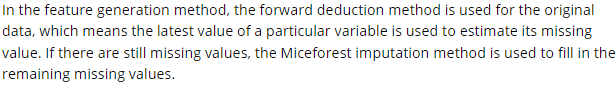

In [10]:
columns_to_count = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
                    'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
                    'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
                    'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
                    'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
                    'Fibrinogen', 'Platelets']

columns_to_diff = ['HR', 'MAP', 'O2Sat', 'Resp', 'SBP']

columns_to_stats = ['WBC', 'Temp', 'MAP', 'SBP', 'Creatinine', 'Platelets', 
                     'FiO2', 'SaO2', 'PTT', 'BUN', 'Calcium', 'Phosphate', 
                     'Hct', 'Lactate', 'Alkalinephos', 'Glucose', 'Hgb']

def process_patient_data(dataframe):
    dataframe['ICULOS'] = dataframe['ICULOS'].astype(int)
    dataframe.sort_values(by=['ICULOS'], inplace=True)
    dataframe['Count'] = dataframe.apply(lambda row: count_non_nan(row, columns_to_count), axis=1)
    dataframe['Count'] = dataframe['Count'].cumsum()
    dataframe['Inspection frequency'] = dataframe['Count']/dataframe['ICULOS']

    medians = {}
    for col in columns_to_diff:
        medians[col] = dataframe[col].median()
        
    sepsis = dataframe['SepsisLabel']
    iculos = dataframe['ICULOS']
    count = dataframe['Count']
    freq = dataframe['Inspection frequency']

    dataframe = dataframe[feature_cols]
    dataframe = dataframe.ffill()

    for column in dataframe.columns:
        if column in column_types:
            dataframe[column] = dataframe[column].astype(column_types[column])
    dataframe = pipe.transform(dataframe)

    dataframe['SepsisLabel'] = sepsis
    dataframe['ICULOS'] = iculos
    dataframe['Count'] = count
    dataframe['Inspection frequency'] = freq
        
    for col in columns_to_diff:
        dataframe[f'{col}_2h_diff'] = np.nan
        for i in range(len(dataframe)):
            current_time = dataframe.iloc[i]['ICULOS']
            if current_time > 2:
                past_value = dataframe[(dataframe['ICULOS'] == current_time - 2)][col]
                if not past_value.empty:
                    dataframe.at[i, f'{col}_2h_diff'] = dataframe.at[i, col] - past_value.values[0]
            else:
                dataframe.at[i, f'{col}_2h_diff'] = dataframe.at[i, col] - medians[col]

    for col in columns_to_stats:
        dataframe = calculate_stats(dataframe, col, 12)
        dataframe = calculate_stats(dataframe, col, 24)

    dataframe['HR/SBP'] = dataframe['HR'] / dataframe['SBP']
    dataframe['SaO2/FiO2'] = dataframe['SaO2'] / dataframe['FiO2']
    dataframe = calculate_qSOFA(dataframe)
    return dataframe

In [ ]:
# samples_A = pd.DataFrame()
# index = 1
# for df in dfs:
#     df = process_patient_data(df)
#     samples_A = pd.concat([samples_A, df], ignore_index=True)
#     print(index)
#     index += 1

# dfs = None
# samples_A.to_csv('feature_generation_method_samples_A.csv', index=False)

In [ ]:
# total_samples = len(samples_A)

# total_sepsis_1 = (samples_A['SepsisLabel'] == 1).sum()

# total_sepsis_0 = (samples_A['SepsisLabel'] == 0).sum()

# print(f'Total de amostras: {total_samples}')
# print(f'Total de amostras com SepsisLabel = 1: {total_sepsis_1}')
# print(f'Total de amostras com SepsisLabel = 0: {total_sepsis_0}')

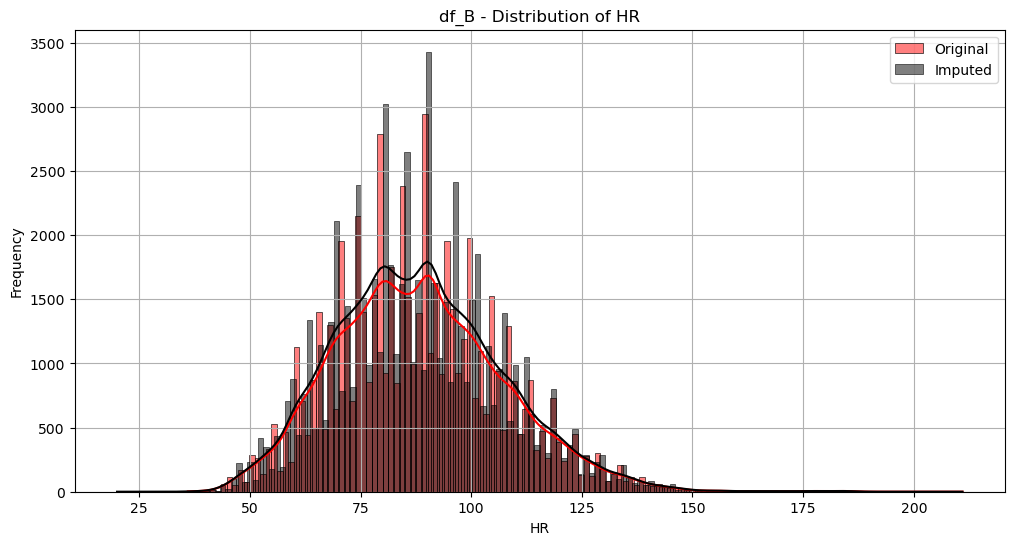

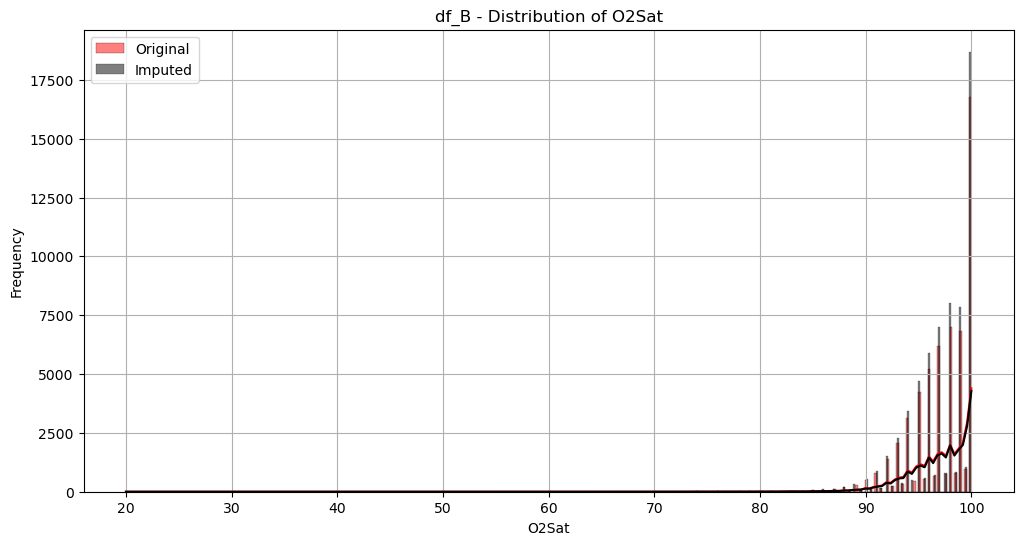

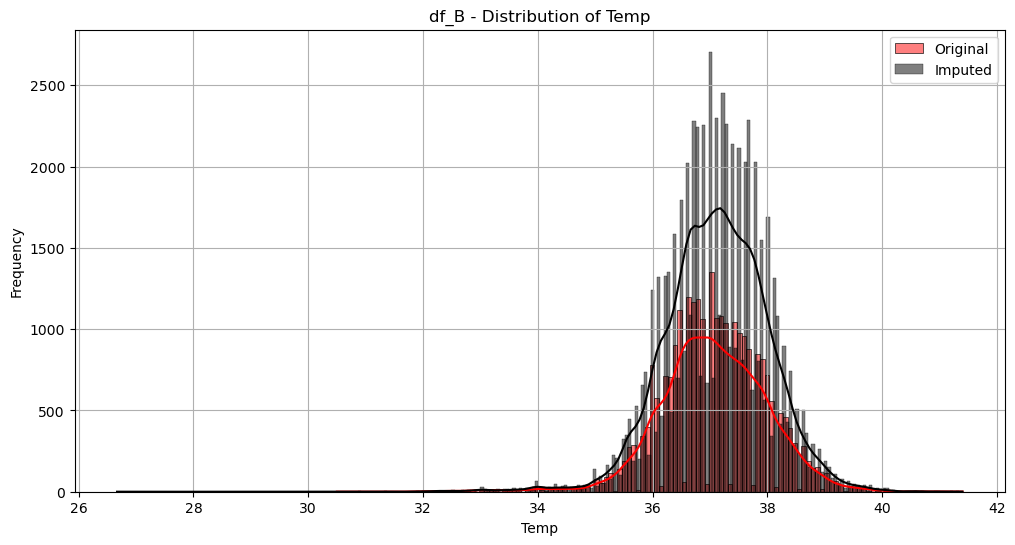

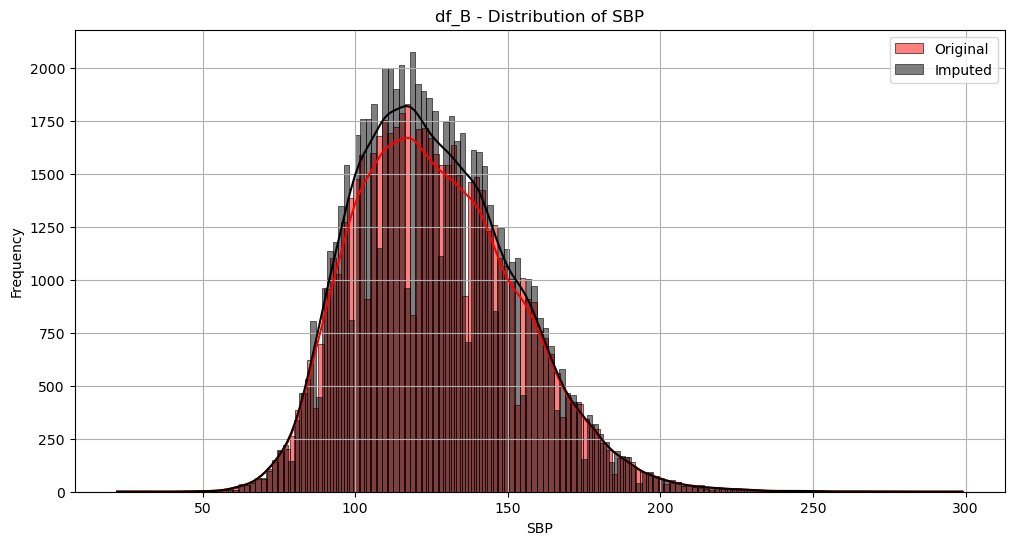

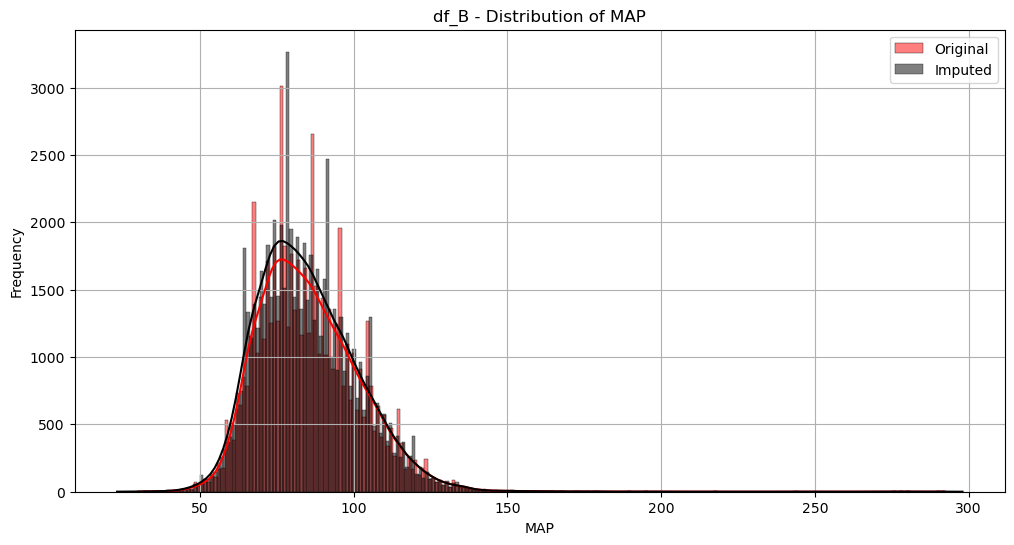

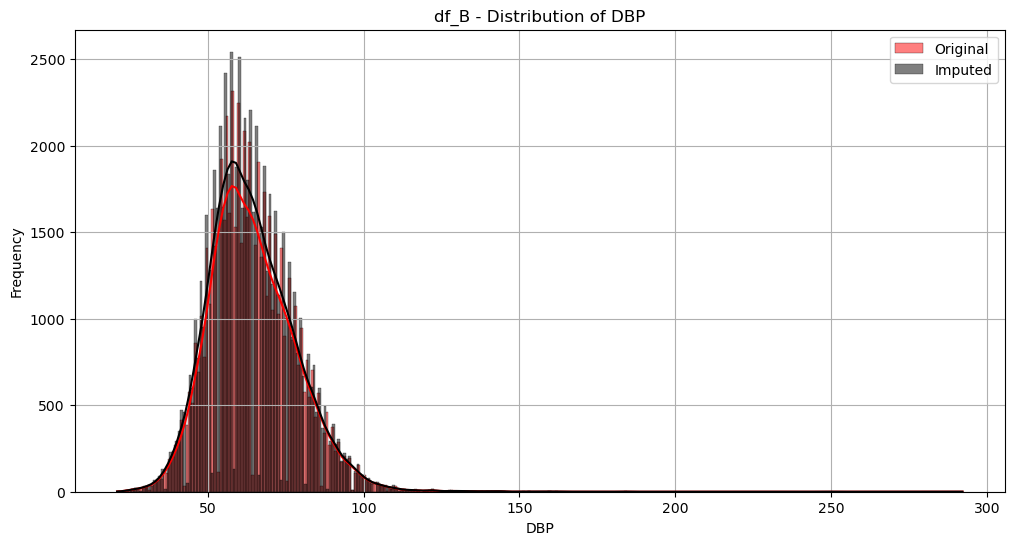

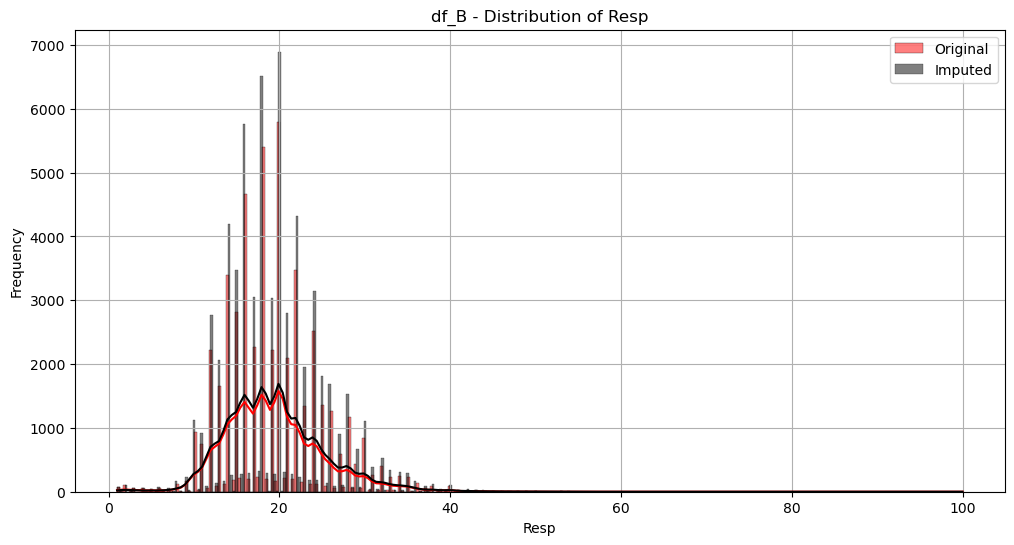

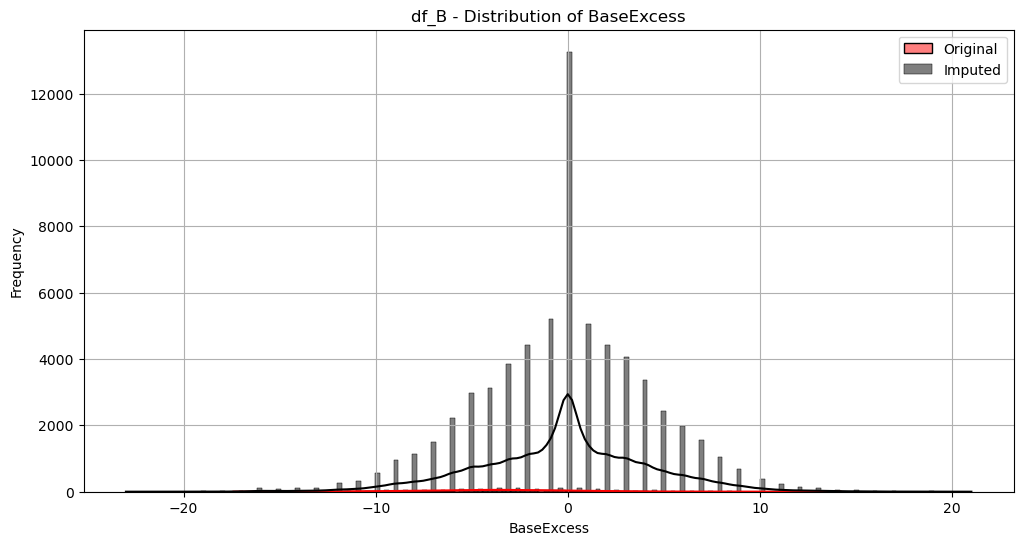

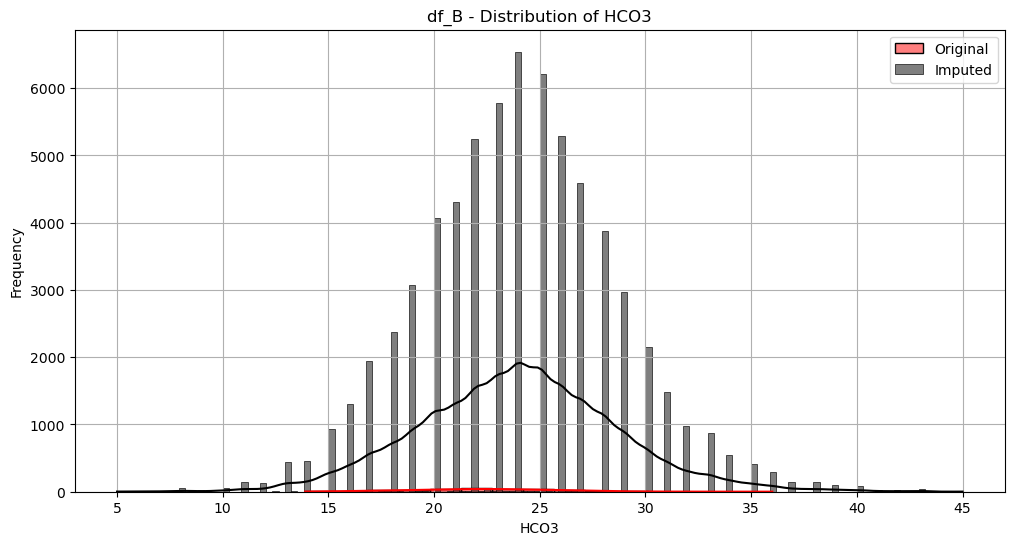

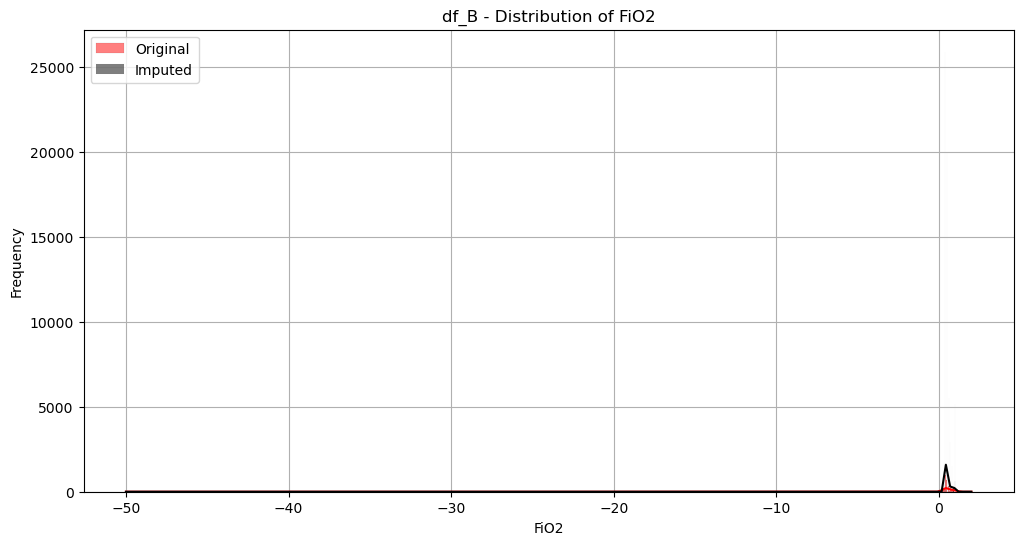

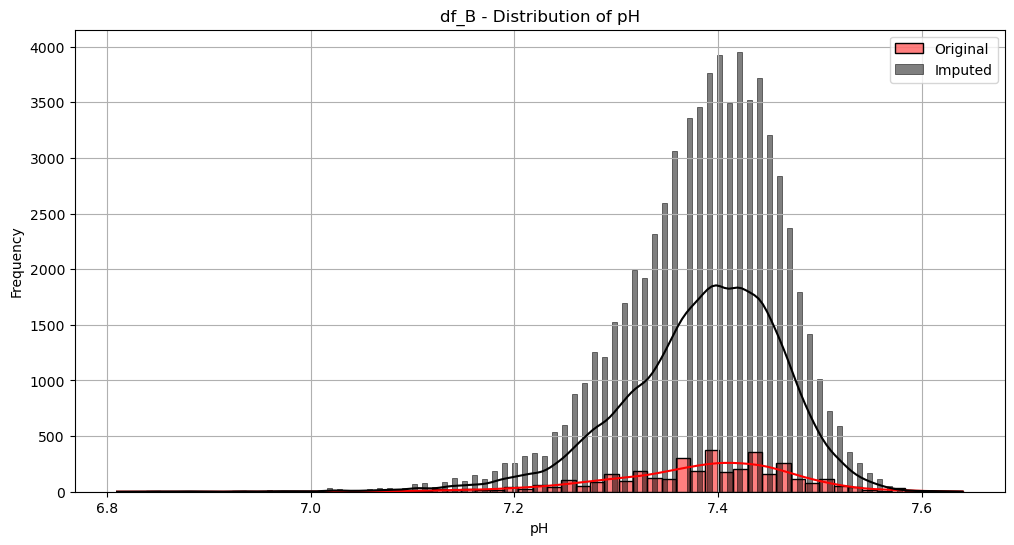

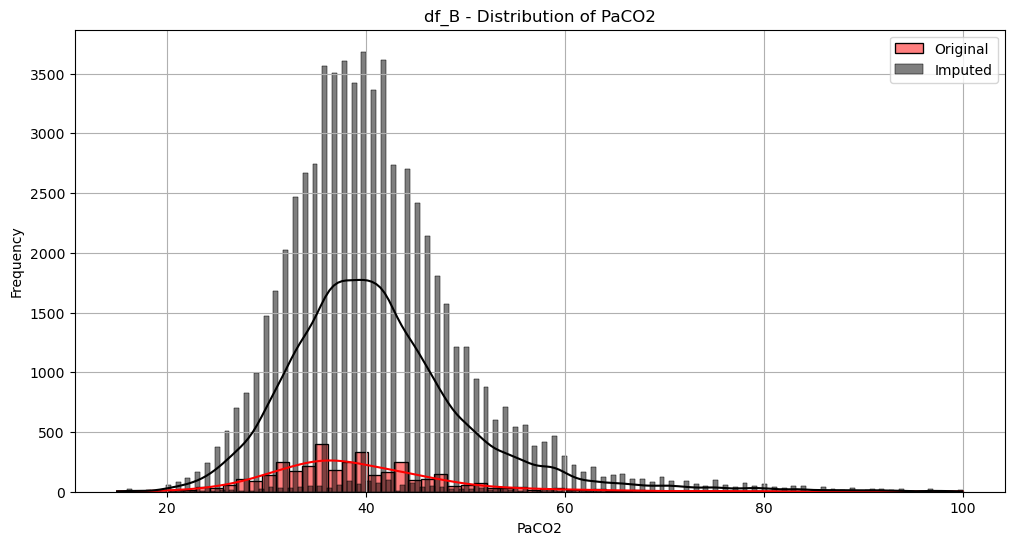

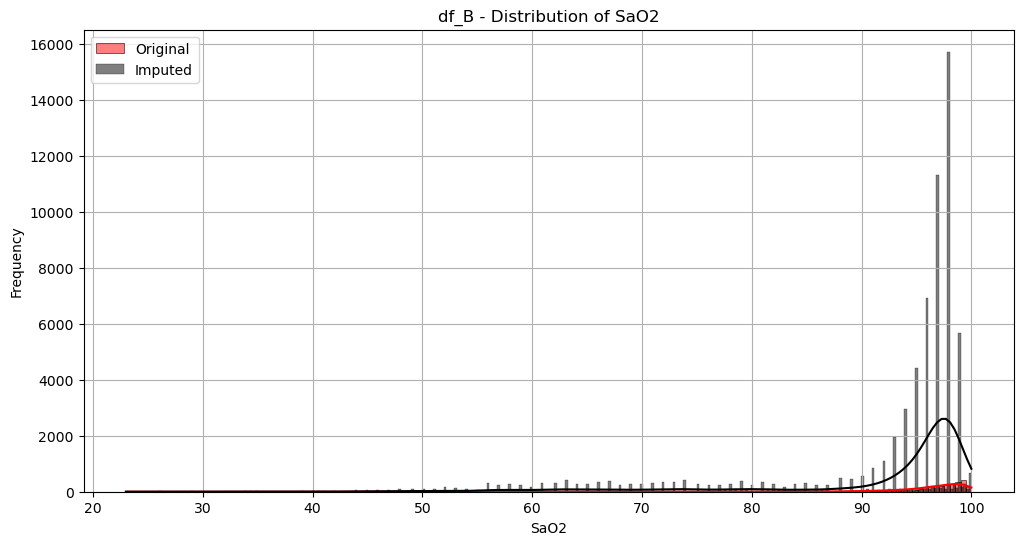

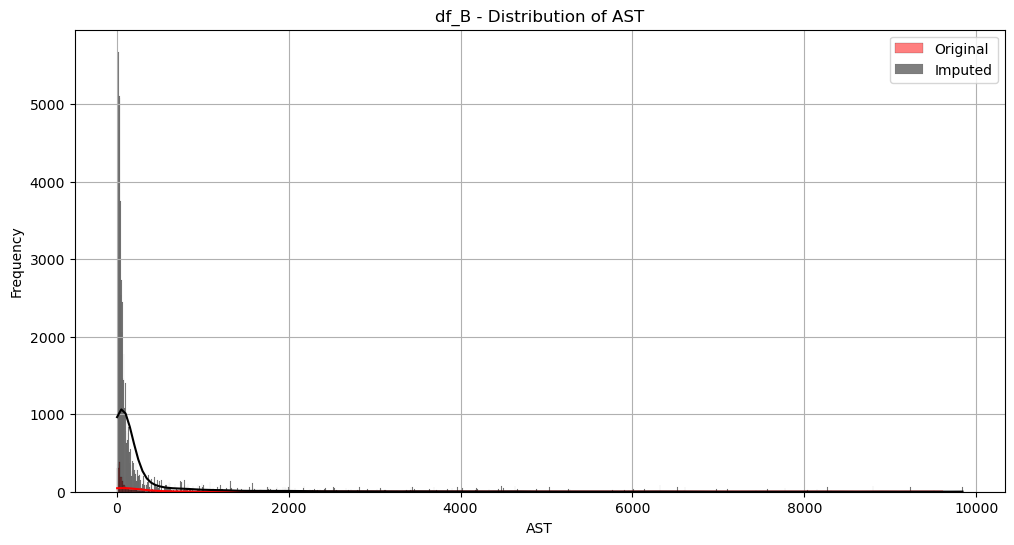

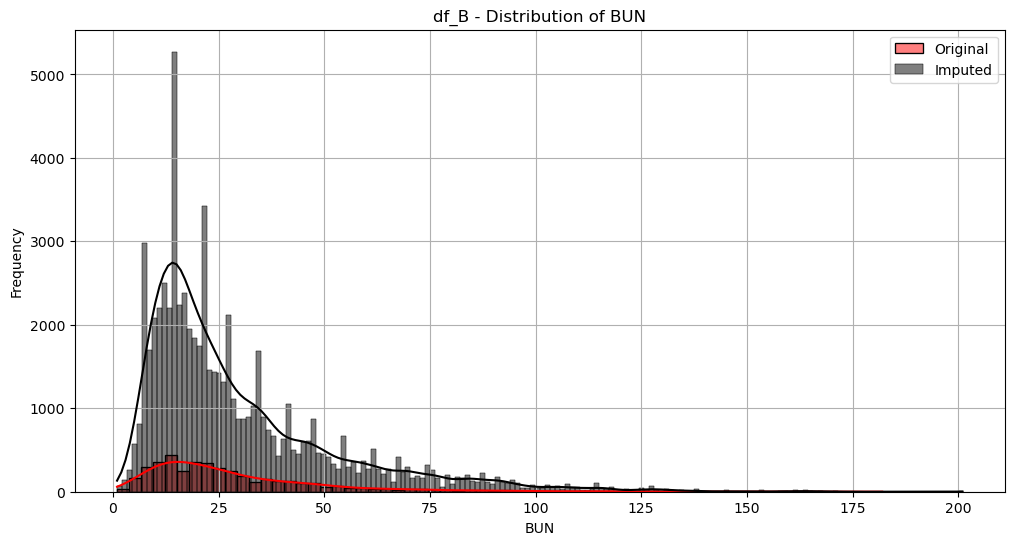

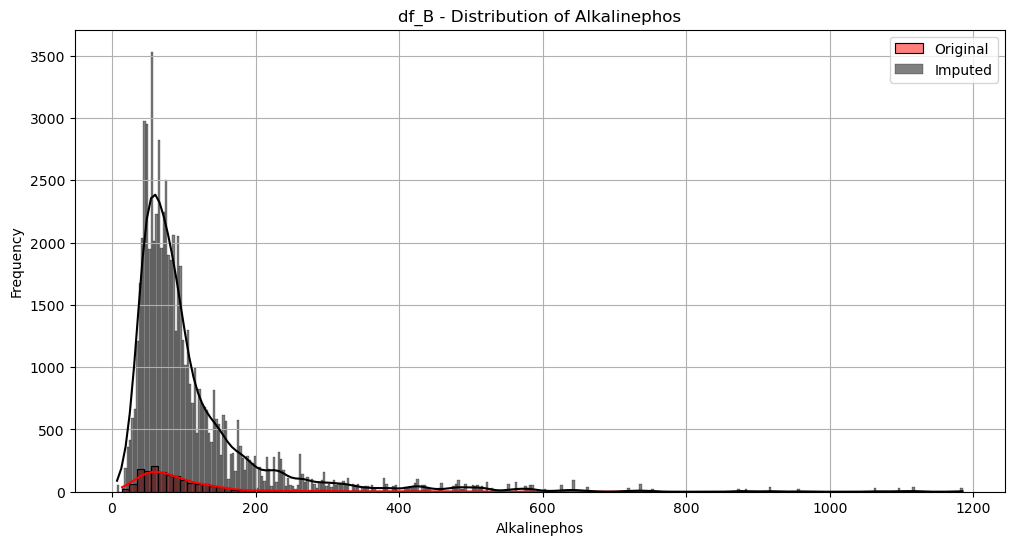

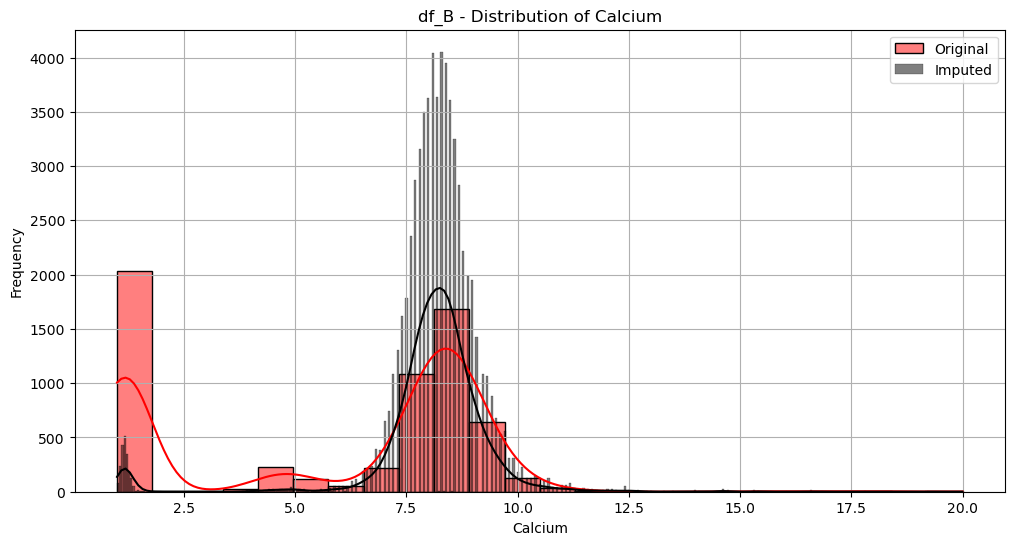

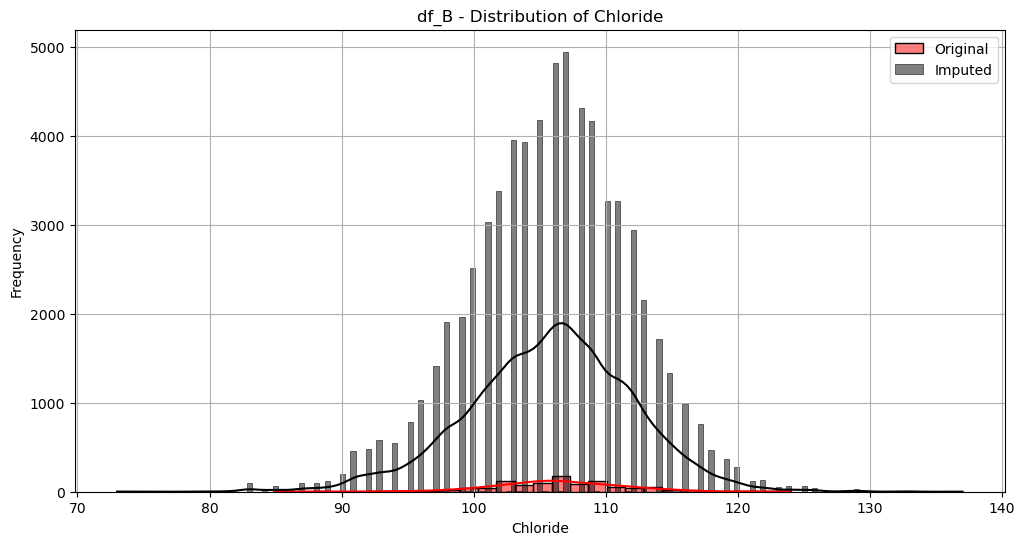

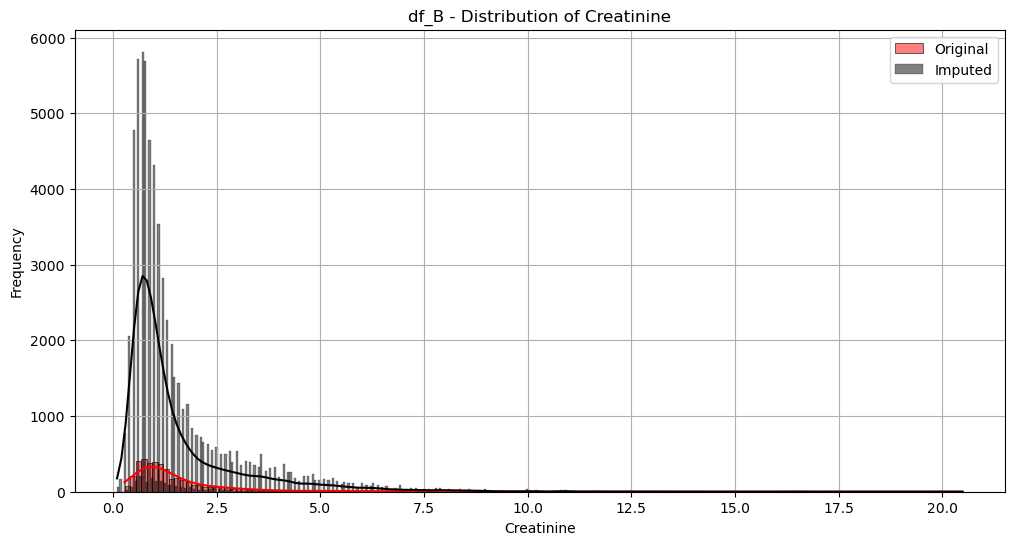

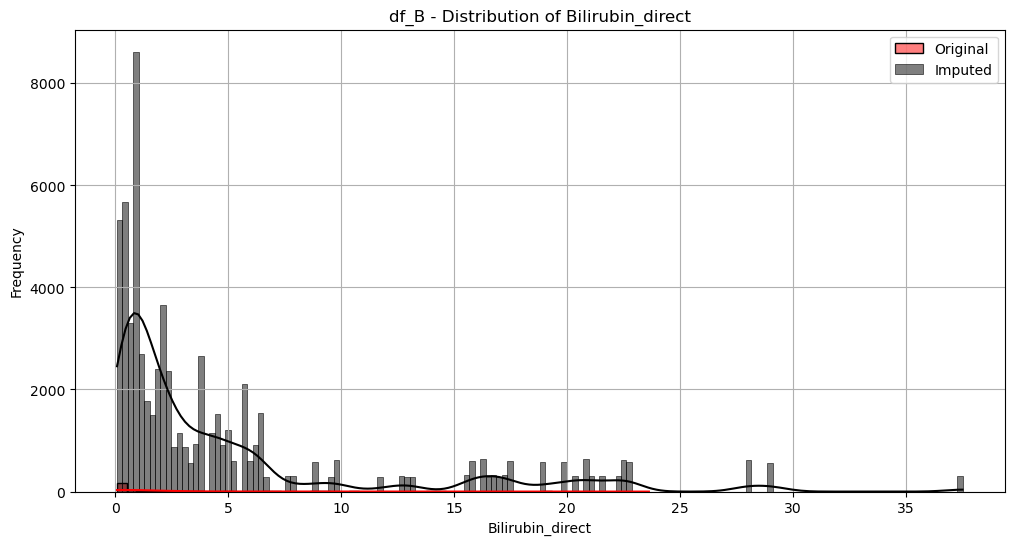

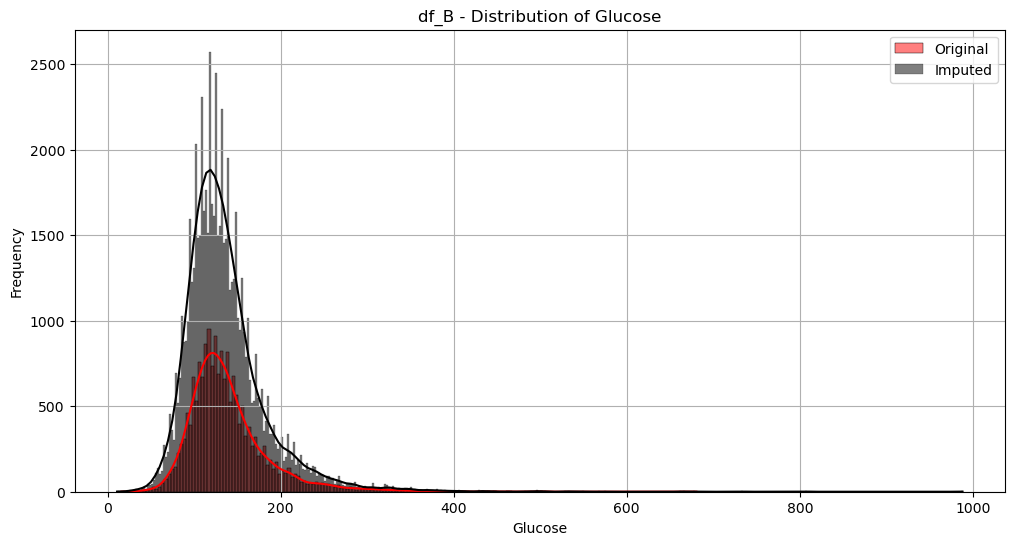

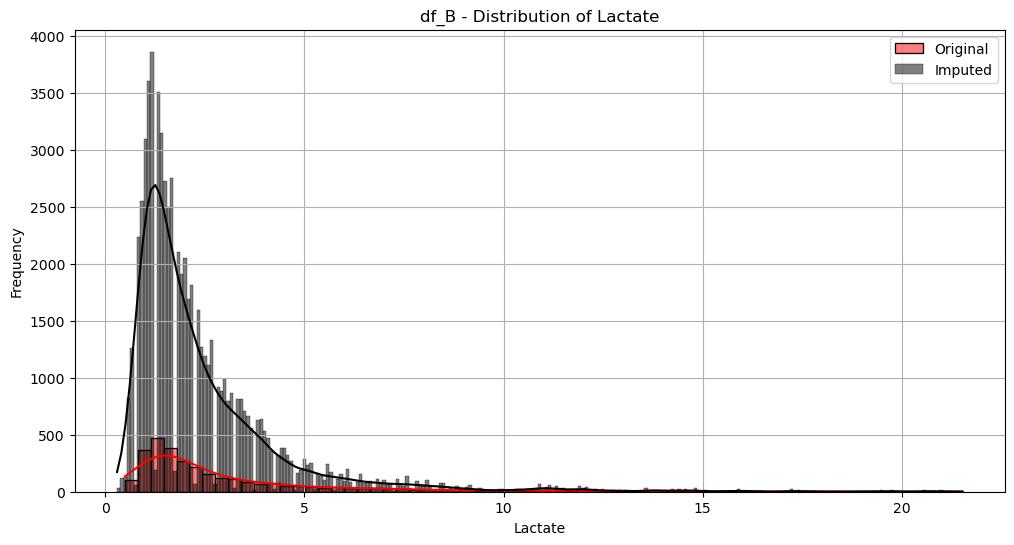

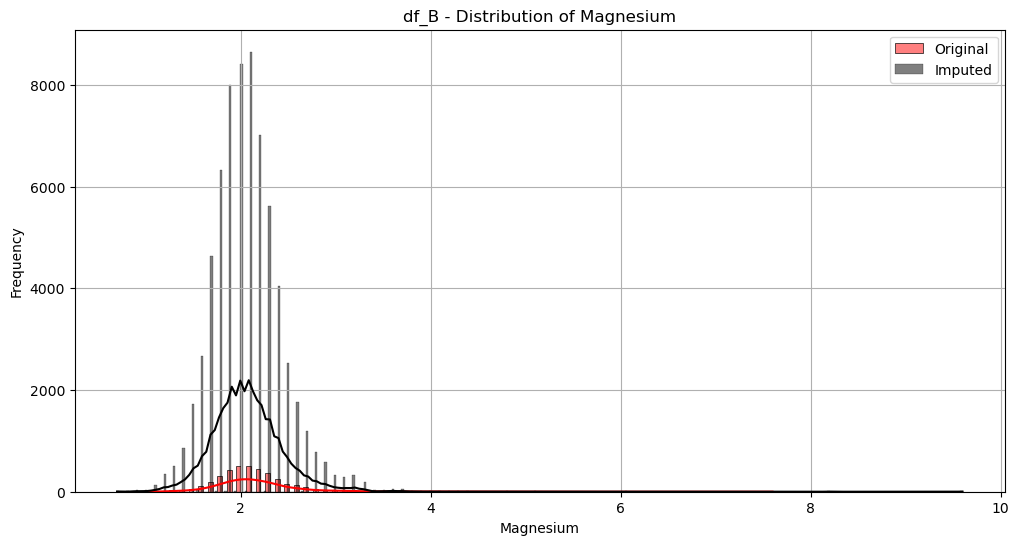

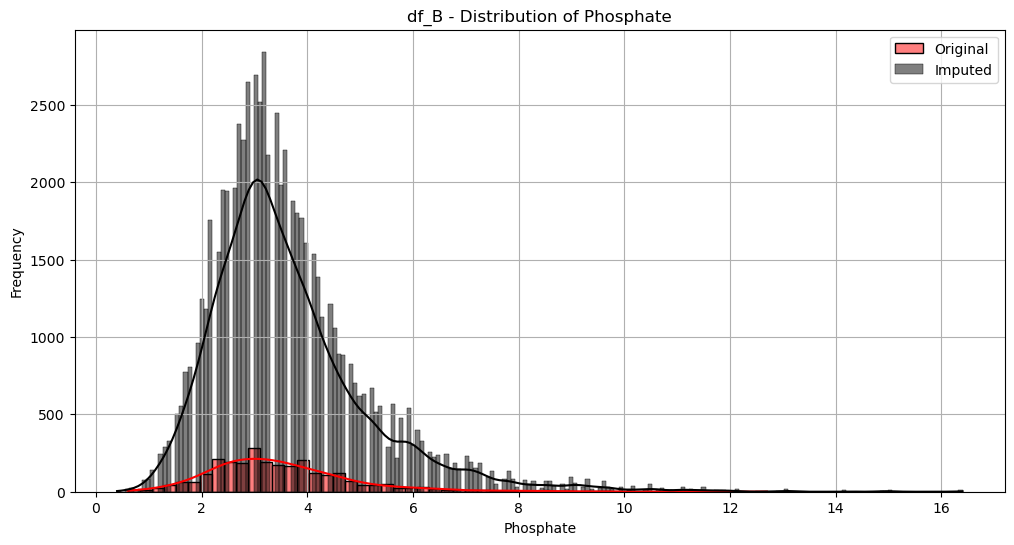

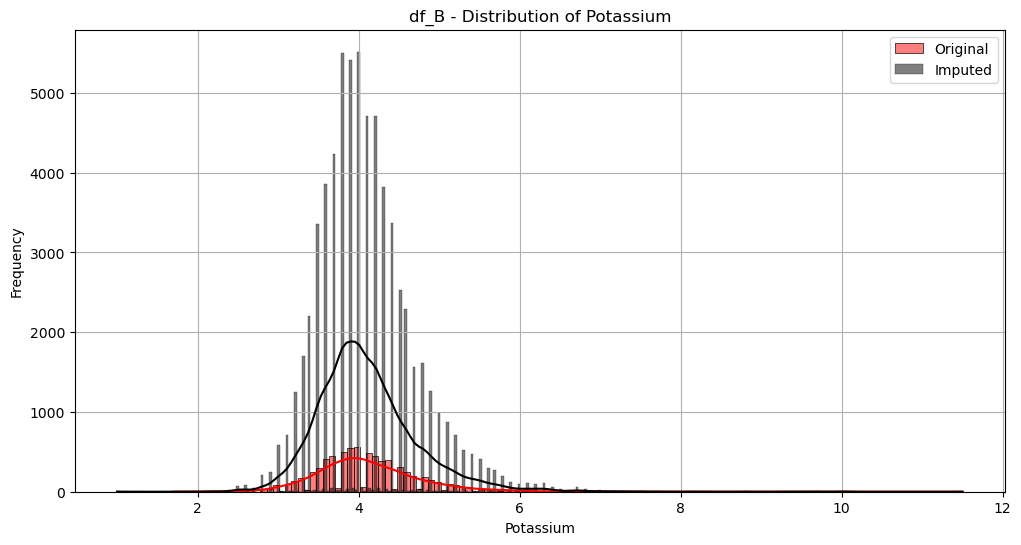

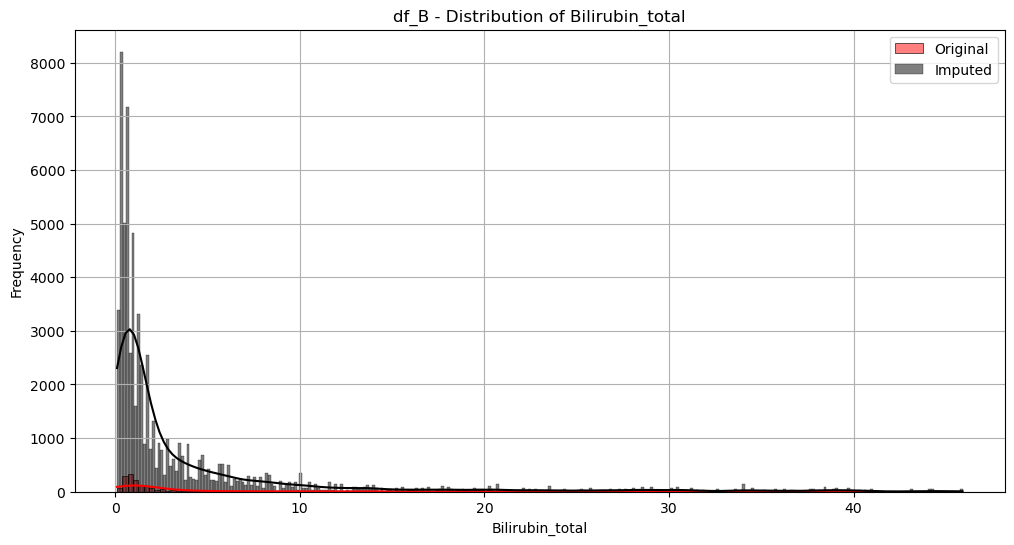

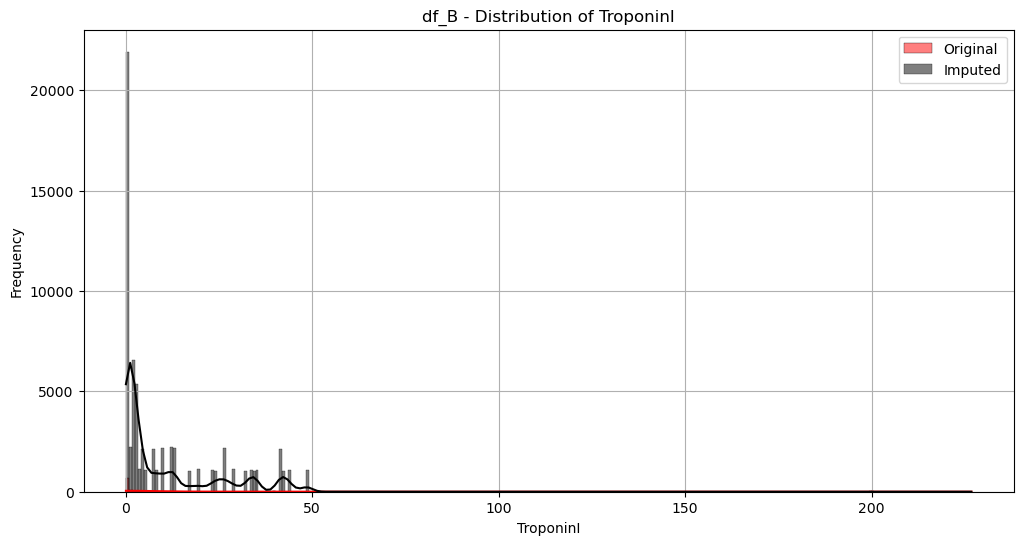

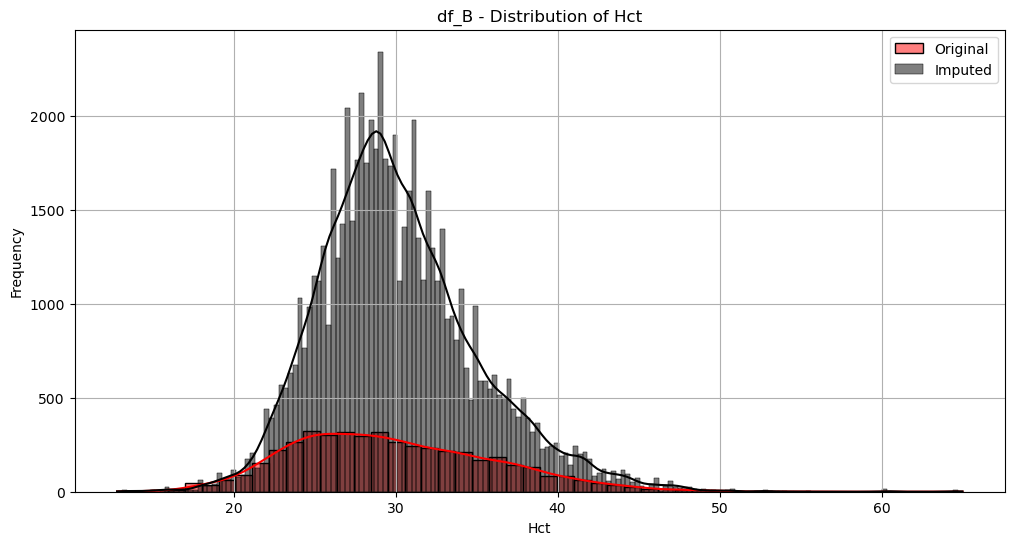

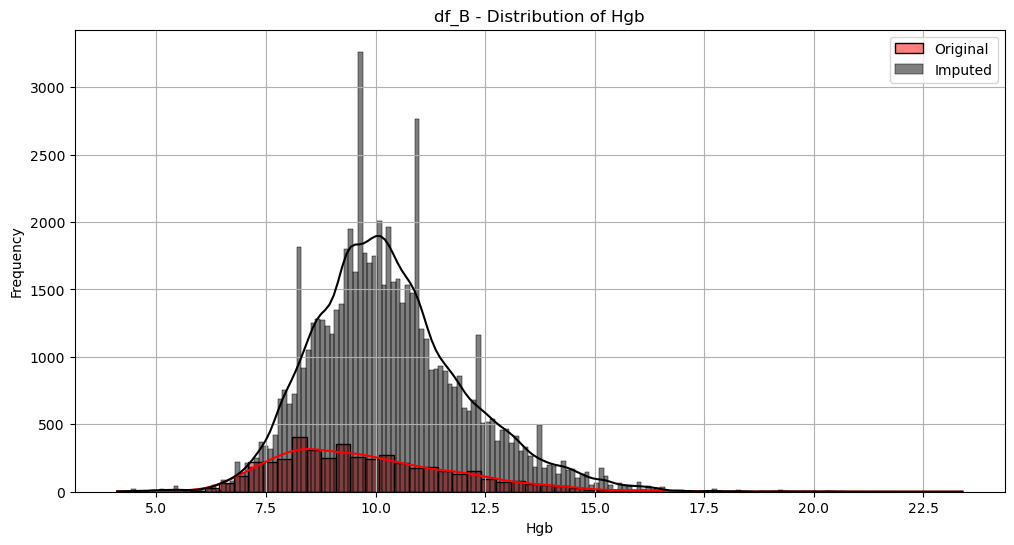

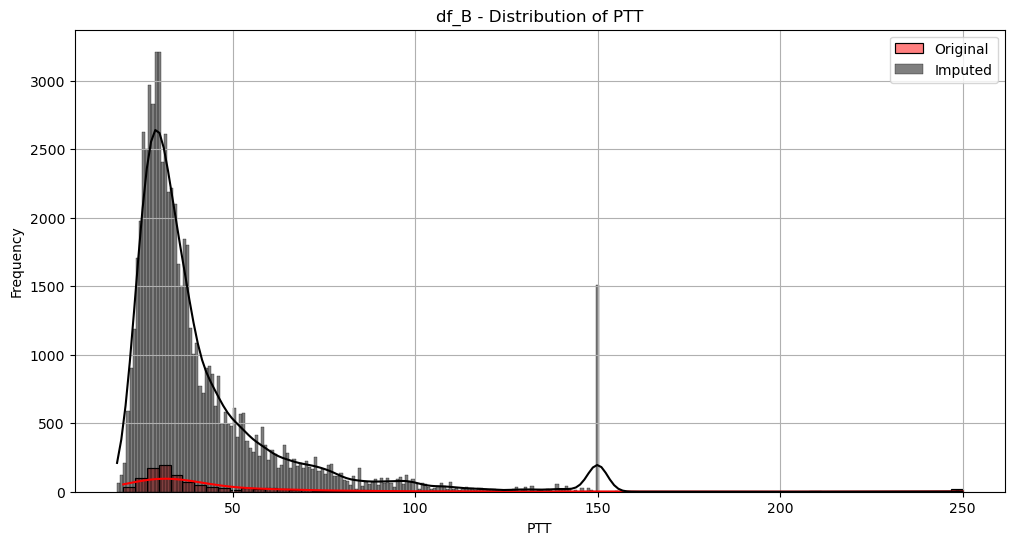

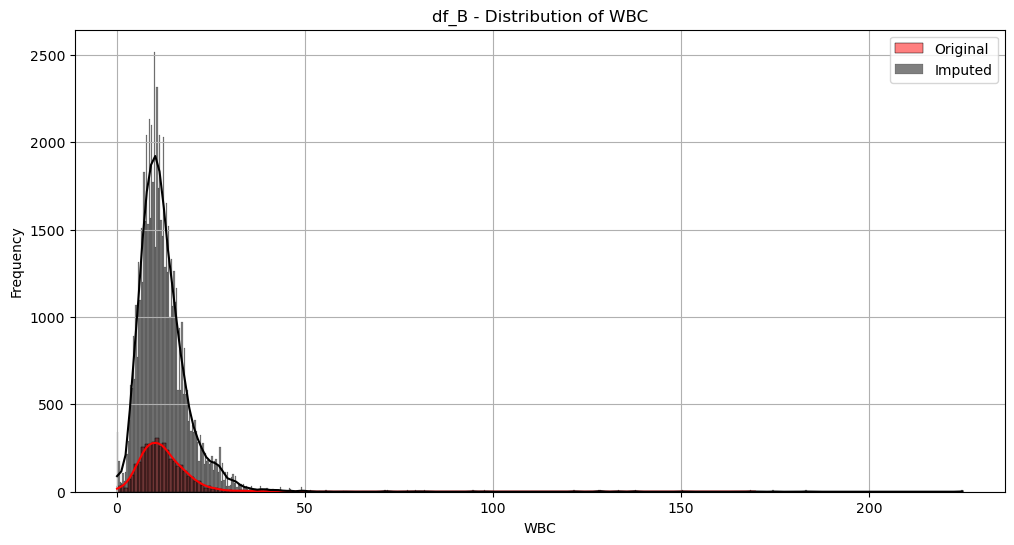

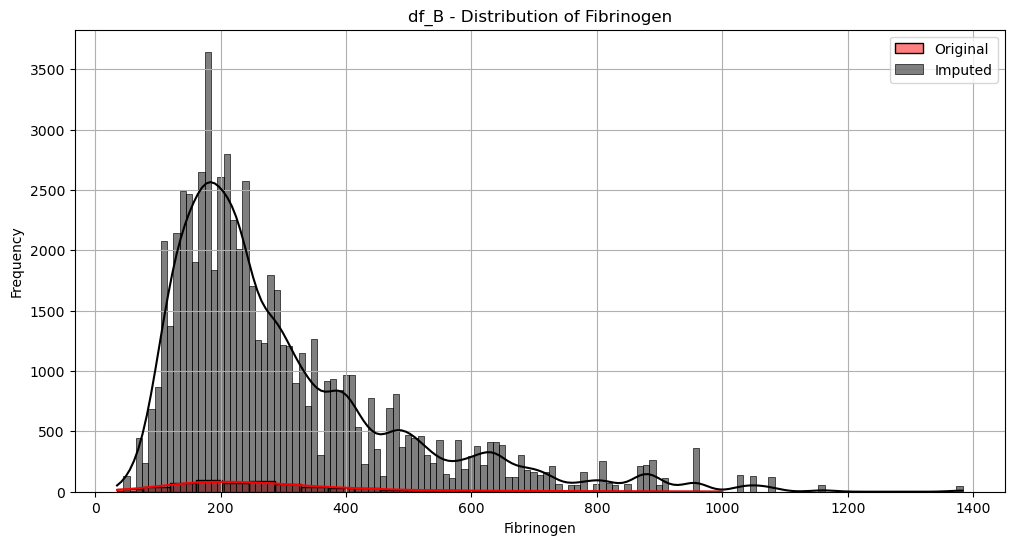

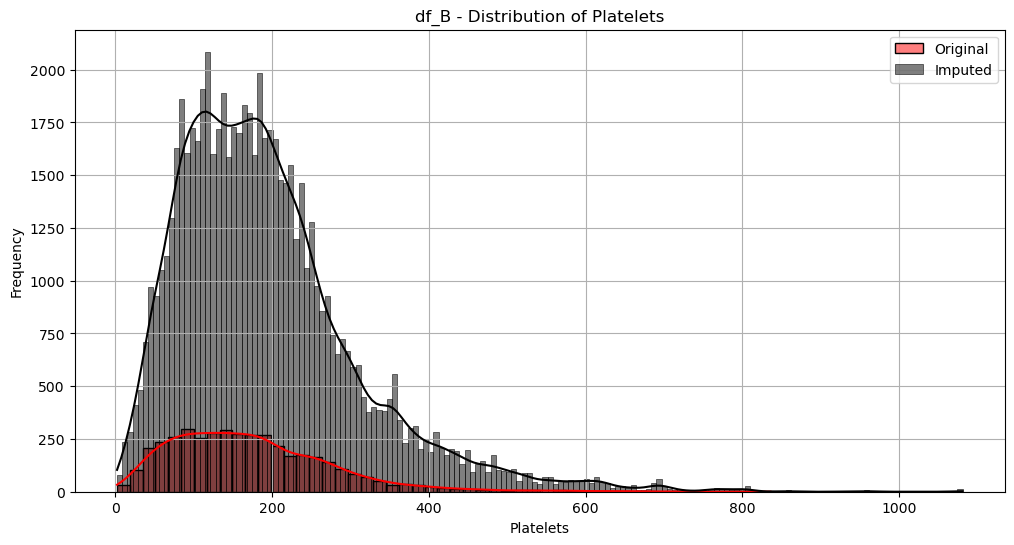

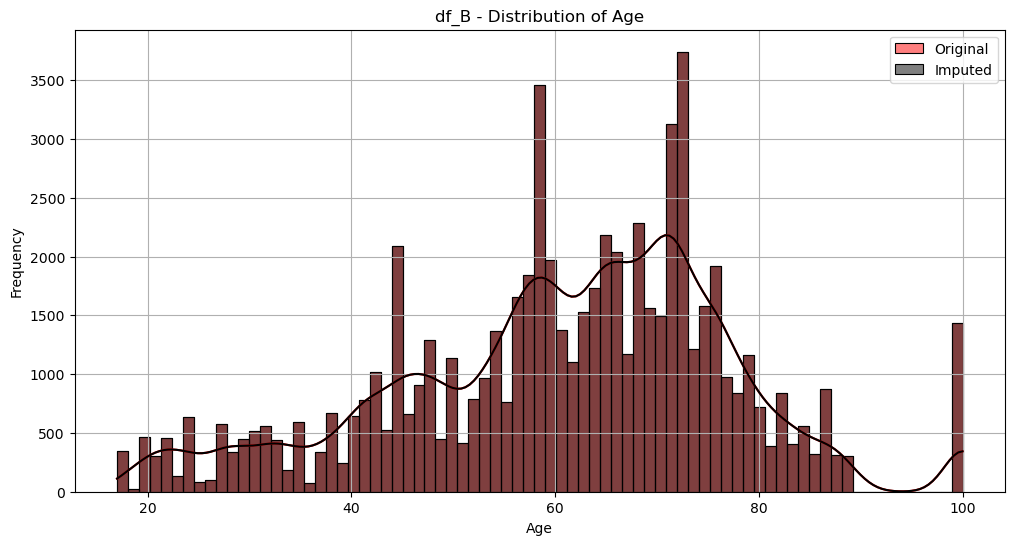

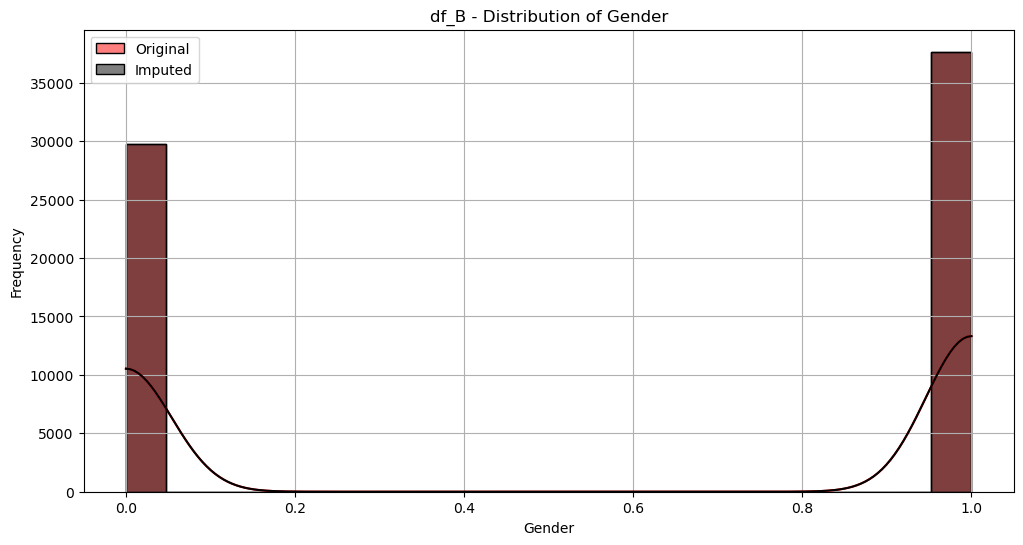

In [11]:
df_B = pd.concat(dfs_B, ignore_index=True)
df_B = df_B[feature_cols]

df_B_transformed = pipe.transform(X=df_B)

plot_distribution_comparison(df_B, df_B_transformed, df_B.columns, 'df_B')

In [18]:
# samples_B = pd.DataFrame()
# index = 1
# for df in dfs_B:
#     df = process_patient_data(df, True)
#     samples_B = pd.concat([samples_B, df], ignore_index=True)
#     print(index)
#     index += 1

# dfs_B = None
# samples_B.to_csv('feature_generation_method_samples_B.csv', index=False)

In [9]:
samples_A = pd.read_csv('feature_generation_method_samples_A.csv')
sepsis_label_A = samples_A['SepsisLabel']
samples_A = samples_A.drop(columns=['SepsisLabel', 'ICULOS', 'Count'])

epsilon = 1e-10
samples_A['FiO2'] = samples_A['FiO2'].replace(0, epsilon)
samples_A['SaO2/FiO2'] = samples_A['SaO2'] / samples_A['FiO2']

### Machine Learning Methods to Predict Early Sepsis

In [10]:
def generate_prediction(model_, X_test_, y_test_, title):
    y_pred = model_.predict(X_test_)
    accuracy = accuracy_score(y_test_, y_pred)
    print(f'Accuracy: {accuracy}')
    print(classification_report(y_test_, y_pred, digits=4))
    
    y_prob = model_.predict_proba(X_test_)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_, y_prob)
    results_df = pd.DataFrame({
        'y_true': y_test_,
        'y_prob': y_prob
    })
    results_df.to_csv("../resultados/zhao_reproducao_original.csv")
    roc_auc = auc(fpr, tpr)
    auroc = roc_auc_score(y_test_, y_pred)
    print(f"AUROC: {roc_auc:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic {title}')
    plt.legend(loc='lower right')
    plt.show()
    
    conf_matrix = confusion_matrix(y_test_, y_pred)
    print(f"Confusion Matrix:")
    print(conf_matrix)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', 
                xticklabels=['No Sepsis', 'Sepsis'], 
                yticklabels=['No Sepsis', 'Sepsis'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {title}')
    plt.show()

Accuracy: 0.9182576883502915
              precision    recall  f1-score   support

           0     0.9197    0.9886    0.9529     21955
           1     0.9050    0.5581    0.6904      4286

    accuracy                         0.9183     26241
   macro avg     0.9124    0.7733    0.8217     26241
weighted avg     0.9173    0.9183    0.9100     26241

AUROC: 0.9662


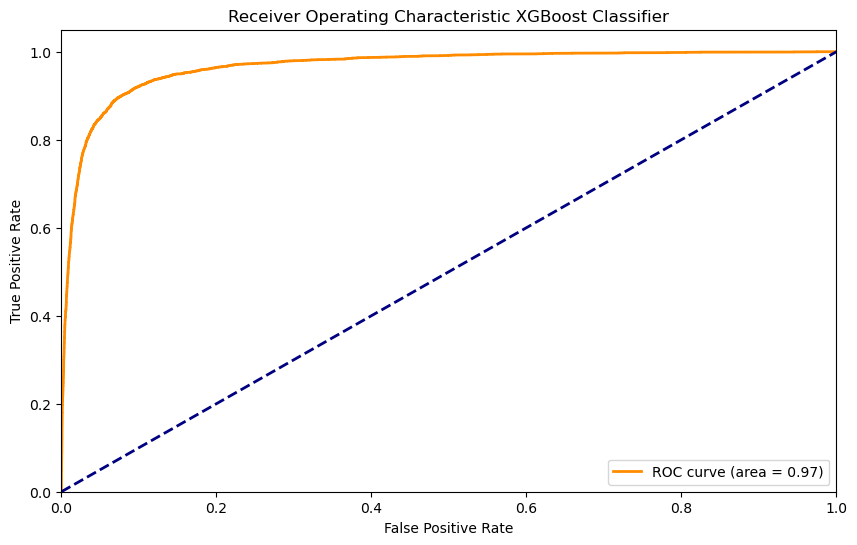

Confusion Matrix:
[[21704   251]
 [ 1894  2392]]


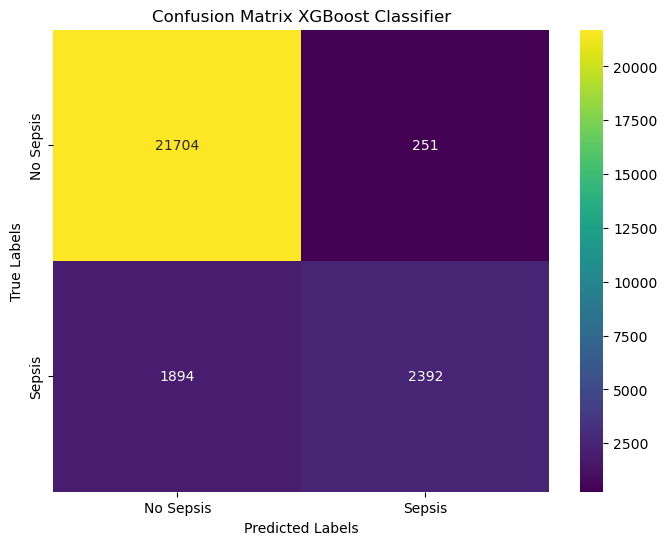

In [13]:
X_train, X_test, y_train, y_test = train_test_split(samples_A, sepsis_label_A, test_size=0.25, random_state=182)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb_model.fit(X_train, y_train)

generate_prediction(xgb_model, X_test, y_test, 'XGBoost Classifier')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12850, number of negative: 65873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26045
[LightGBM] [Info] Number of data points in the train set: 78723, number of used features: 146
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163231 -> initscore=-1.634385
[LightGBM] [Info] Start training from score -1.634385
Accuracy: 0.8573606188788537
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     21955
           1       0.94      0.14      0.24      4286

    accuracy                           0.86     26241
   macro avg       0.90      0.57      0.58     26241
weighted avg       0.87      0.86      0.81     26241

AUROC: 0.5670


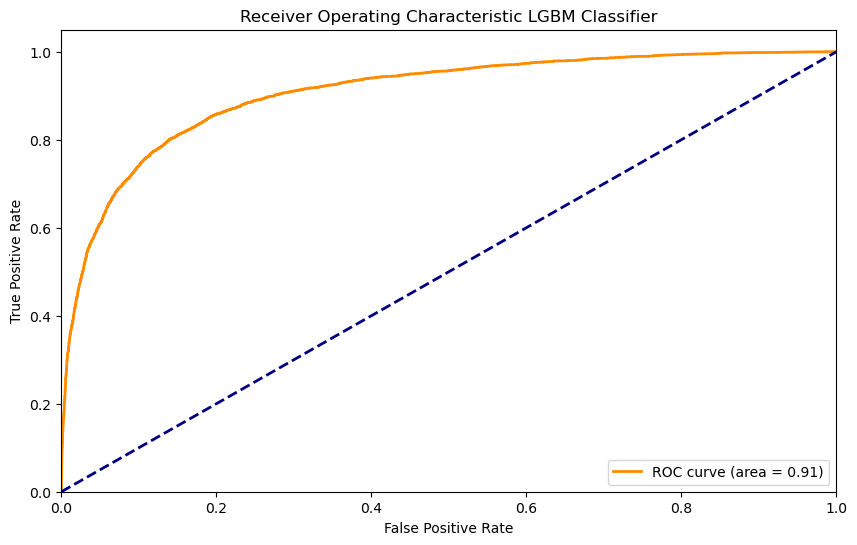

Confusion Matrix:
[[21916    39]
 [ 3704   582]]


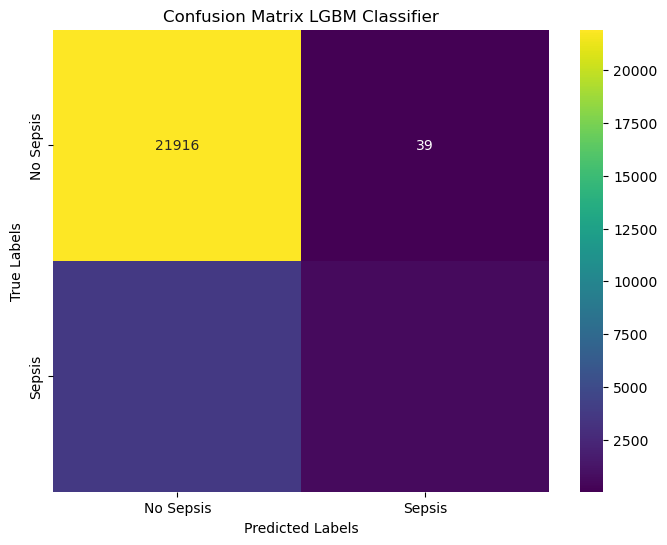

In [5]:
lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')
lgb_model.fit(X_train, y_train)

generate_prediction(lgb_model, X_test, y_test, 'LGBM Classifier')

## Transductive Conformal Prediction for binary classification
    - https://github.com/PacktPublishing/Practical-Guide-to-Applied-Conformal-Prediction/blob/main/Chapter_05_TCP.ipynb

In [1]:
%matplotlib inline
from scipy.stats import rankdata
import openml

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import label_binarize

import plotly.express as px

In [19]:
def InverseProbabilityNC(predicted_score, y):
  prob = np.zeros(y.size, dtype=np.float32)
  for i, y_ in enumerate(y):
    if y_ >= predicted_score.shape[1]:
      prob[i] = 0
    else:
      prob[i] = predicted_score[i, int(y_)]
  return 1 - prob

def compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
  p_values = []
  if not isinstance(non_conformity_scores_test, list):
    non_conformity_scores_test = [non_conformity_scores_test]

  for i, test_point_conformity_score in enumerate(non_conformity_scores_test):
    p_value = (np.sum(non_conformity_scores_train >= test_point_conformity_score) + 1) / (len(non_conformity_scores_train)+1)
    p_values.append(p_value)  
  return np.array(p_values)

# Function computes prediction sets - here we essentially collect all the steps done above into one function
# Function takes training set, test points, underlying classifier, significance level
# Function returns for each test point, prediction sets and two sets of p-values for each potential label 0 & 1 
def prediction_sets(X_train, y_train, X_test, y_test, model = LogisticRegression(), significance_level = 0.05):

    prediction_sets = []
    p_values_class_0 = []
    p_values_class_1 = []
    predictions_test_set = []

    for i,y in enumerate(y_test):
      print(i)
      # add test point to the training set 
      X_train_plus_test = pd.concat([X_train,pd.DataFrame(X_test.iloc[i]).T])
      y_train_plus_test_0 = np.append(y_train, 0)
      y_train_plus_test_1 = np.append(y_train, 1)

      # train the underlying classifier twice - two models for each potential value of the lable - 0 and 1
      model.fit(X_train_plus_test, y_train_plus_test_0)
      y_pred_score_train_plus_test_0 = model.predict_proba(X_train_plus_test)
      model.fit(X_train_plus_test, y_train_plus_test_1)
      y_pred_score_train_plus_test_1 = model.predict_proba(X_train_plus_test)

      #compute nonconformity scores
      non_conformity_scores_train_plus_test_0 = InverseProbabilityNC(y_pred_score_train_plus_test_0, y_train_plus_test_0)
      non_conformity_scores_train_plus_test_1 = InverseProbabilityNC(y_pred_score_train_plus_test_1, y_train_plus_test_1)

      non_conformity_scores_y_train_class_0 = non_conformity_scores_train_plus_test_0[:-1]
      non_conformity_scores_y_train_class_1 = non_conformity_scores_train_plus_test_1[:-1]

      non_conformity_scores_y_test_class_0 = non_conformity_scores_train_plus_test_0[-1]
      non_conformity_scores_y_test_class_1 = non_conformity_scores_train_plus_test_1[-1]

      p_value_class_0 = compute_p_value(non_conformity_scores_y_train_class_0, non_conformity_scores_y_test_class_0)
      p_value_class_1 = compute_p_value(non_conformity_scores_y_train_class_1, non_conformity_scores_y_test_class_1)

      p_values_class_0.append( p_value_class_0)
      p_values_class_1.append( p_value_class_1)
        
      if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
          prediction_sets.append([True, True])
      elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
          prediction_sets.append([True, False])
      elif (p_value_class_0 <= significance_level) and (p_value_class_1 > significance_level):
          prediction_sets.append([False, True])
      else:  
          prediction_sets.append([False, False])

    return prediction_sets, p_values_class_0, p_values_class_1

In [11]:
X_train, X_test, y_train, y_test = train_test_split(samples_A, sepsis_label_A, test_size=0.25, random_state=182)

predictions_test_sets, p_values_test_set_class_0, p_values_test_set_class_1  = prediction_sets(
    X_train, y_train, X_test, y_test, model=xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), significance_level = 0.05)

In [24]:
significance_level = 0.05
prediction_sets = []
p_values_class_0 = []
p_values_class_1 = []
predictions_test_set = []

for i,y in enumerate(y_test):
  print(i)
  # add test point to the training set 
  X_train_plus_test = pd.concat([X_train,pd.DataFrame(X_test.iloc[i]).T])
  y_train_plus_test_0 = np.append(y_train, 0)
  y_train_plus_test_1 = np.append(y_train, 1)

  model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')
  # train the underlying classifier twice - two models for each potential value of the lable - 0 and 1
  model.fit(X_train_plus_test, y_train_plus_test_0)
  y_pred_score_train_plus_test_0 = model.predict_proba(X_train_plus_test)

  model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')
  model.fit(X_train_plus_test, y_train_plus_test_1)
  y_pred_score_train_plus_test_1 = model.predict_proba(X_train_plus_test)

  #compute nonconformity scores
  non_conformity_scores_train_plus_test_0 = InverseProbabilityNC(y_pred_score_train_plus_test_0, y_train_plus_test_0)
  non_conformity_scores_train_plus_test_1 = InverseProbabilityNC(y_pred_score_train_plus_test_1, y_train_plus_test_1)

  non_conformity_scores_y_train_class_0 = non_conformity_scores_train_plus_test_0[:-1]
  non_conformity_scores_y_train_class_1 = non_conformity_scores_train_plus_test_1[:-1]

  non_conformity_scores_y_test_class_0 = non_conformity_scores_train_plus_test_0[-1]
  non_conformity_scores_y_test_class_1 = non_conformity_scores_train_plus_test_1[-1]

  p_value_class_0 = compute_p_value(non_conformity_scores_y_train_class_0, non_conformity_scores_y_test_class_0)
  p_value_class_1 = compute_p_value(non_conformity_scores_y_train_class_1, non_conformity_scores_y_test_class_1)

  p_values_class_0.append( p_value_class_0)
  p_values_class_1.append( p_value_class_1)
    
  if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
      prediction_sets.append([True, True])
  elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
      prediction_sets.append([True, False])
  elif (p_value_class_0 <= significance_level) and (p_value_class_1 > significance_level):
      prediction_sets.append([False, True])
  else:  
      prediction_sets.append([False, False])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
import pickle

with open(f'feature_generation_method_p_values_class_0.pkl', 'wb') as f:
    pickle.dump(p_values_class_0, f)

with open(f'feature_generation_method_p_values_class_1.pkl', 'wb') as f:
    pickle.dump(p_values_class_1, f)

In [3]:
import pickle

with open(f'feature_generation_method_p_values_class_0.pkl', 'rb') as f:
    p_values_test_set_class_0 = pickle.load(f)

with open(f'feature_generation_method_p_values_class_1.pkl', 'rb') as f:
    p_values_test_set_class_1 = pickle.load(f)

In [23]:
p_values_test_set_class_0

[array([0.98053961]),
 array([0.98454093]),
 array([0.50201971]),
 array([0.73776739]),
 array([0.39901428]),
 array([0.06427519]),
 array([0.83865149]),
 array([0.30295717]),
 array([0.10709568]),
 array([0.06687922]),
 array([0.56254763]),
 array([0.16454957]),
 array([0.28335704]),
 array([0.77736141]),
 array([0.85456786]),
 array([0.70377521]),
 array([0.85698135]),
 array([0.73868198]),
 array([0.760251]),
 array([0.49308978]),
 array([0.7870535]),
 array([0.71359433]),
 array([0.56473248]),
 array([0.03930186]),
 array([0.78254408]),
 array([0.56912758]),
 array([0.13261521]),
 array([0.52041309]),
 array([0.95376251]),
 array([0.00725319]),
 array([0.9990346]),
 array([0.60557136]),
 array([0.46707484]),
 array([0.74846298]),
 array([0.04863828]),
 array([0.61898532]),
 array([0.70103145]),
 array([0.57417052]),
 array([0.22387074]),
 array([0.40405721]),
 array([0.30891469]),
 array([0.93742696]),
 array([0.80957522]),
 array([0.48705604]),
 array([0.59136985]),
 array([0.8091

In [5]:
def conformal_prediction_metrics(p_values_class_0, p_values_class_1, y_test, significance_level):
    predictions_test_set = []

    for p0, p1 in zip(p_values_class_0, p_values_class_1):
        if (p0 > significance_level) and (p1 > significance_level):
            predictions_test_set.append(0 if p0 > p1 else 1)
        elif (p0 > significance_level) and (p1 <= significance_level):
            predictions_test_set.append(0)
        elif (p0 <= significance_level) and (p1 > significance_level):
            predictions_test_set.append(1)
        else:
            predictions_test_set.append(None)

    valid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is not None]
    invalid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is None]

    # Corrigido: usar iloc para acessar os valores pela posição
    y_test_valid = [y_test.iloc[i] for i in valid_indices]
    y_pred_valid = [predictions_test_set[i] for i in valid_indices]

    accuracy = accuracy_score(y_test_valid, y_pred_valid)
    recall = recall_score(y_test_valid, y_pred_valid)
    f1 = f1_score(y_test_valid, y_pred_valid)
y_score = [1 - p[0] for p in p_values_test_set_class_0]  # Ou p_values_class_1

    # Filtrando os mesmos índices válidos
    y_score_valid = [y_score[i] for i in valid_indices]
    
    fpr, tpr, thresholds = roc_curve(y_test_valid, y_score_valid)
    auroc = auc(fpr, tpr)

    conf_matrix = confusion_matrix(y_test_valid, y_pred_valid)
    report = classification_report(y_test_valid, y_pred_valid, digits=4)

    results_df = pd.DataFrame({
        'y_true': [y_test.iloc[i] for i in valid_indices],
        'y_pred': [y_score[i] for i in valid_indices]
    })
    #results_df.to_csv('../resultados/zhao_cp_original_015.csv')

    coverage_rate = len(valid_indices) / len(y_test)
    set_size = np.mean([
        int(p_values_class_0[i] > significance_level) + int(p_values_class_1[i] > significance_level)
        for i in range(len(y_test))
    ])

    y_test_np = y_test.to_numpy()
    removed_sepsis = np.sum(y_test_np[invalid_indices] == 1)
    removed_no_sepsis = np.sum(y_test_np[invalid_indices] == 0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Coverage Rate: {coverage_rate:.4f}")
    print(f"Set Size (avg prediction set size): {set_size:.4f}")
    print(f"Removed samples (No sepsis): {removed_no_sepsis}")
    print(f"Removed samples (Sepsis): {removed_sepsis}")
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No sepsis', 'Sepsis'],
                yticklabels=['No sepsis', 'Sepsis'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'auroc': auroc,
        'coverage_rate': coverage_rate,
        'set_size': set_size,
        'removed_sepsis': removed_sepsis,
        'removed_no_sepsis': removed_no_sepsis,
        'results_df': results_df
    }


Accuracy: 0.9435
Recall: 0.5962
F1-score: 0.7296
AUROC: 0.9596
Coverage Rate: 0.9463
Set Size (avg prediction set size): 0.9623
Removed samples (No sepsis): 297
Removed samples (Sepsis): 1111

Classification Report:
              precision    recall  f1-score   support

           0     0.9438    0.9944    0.9685     21658
           1     0.9399    0.5962    0.7296      3175

    accuracy                         0.9435     24833
   macro avg     0.9419    0.7953    0.8490     24833
weighted avg     0.9433    0.9435    0.9379     24833



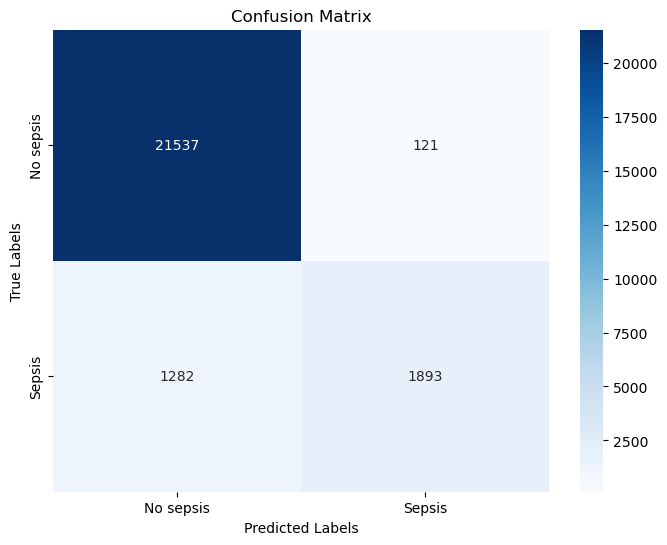

In [17]:
metrics = conformal_prediction_metrics(
    p_values_class_0=p_values_test_set_class_0,
    p_values_class_1=p_values_test_set_class_1,
y_test=y_test,  # Lista ou array com rótulos verdadeiros
    significance_level=0.1
)

In [43]:
invalid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is None]

X_test_invalid = [X_test.iloc[i] for i in invalid_indices]
y_test_invalid = [list(y_test)[i] for i in invalid_indices]

In [45]:
count_of_ones = y_test_invalid.count(1)

print(f'Número de amostras com sepse na lista: {count_of_ones}')

Número de amostras com sepse na lista: 101


In [47]:
count_of_zeros = y_test_invalid.count(0)

print(f'Número de amostras sem sepse na lista: {count_of_zeros}')

Número de amostras sem sepse na lista: 23
